In [1]:
#standard imports
import detprocess as dp
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import math
import qetpy as qp

from pytesdaq.io.hdf5 import H5Reader, getrandevents

from scipy import stats, optimize, interpolate

from matplotlib import rc
rc('text', usetex=False)
rc('font', family="sans-serif")
rc('axes', labelsize=12)
rc('font', size=12)
rc('legend', fontsize=10)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)

h5_reader = H5Reader()

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
run = '_20/'
series = '_D20220909_T173605'
version = 'nos_12hr'
suffix = '/sdata1/runs/run20/processed/'
suffix_analysis = '/data/users/da_real_maggie_reed/analysis/run'+run
#threshtrig_nos_12hr
#threshtrig_nos_12hr_I2_D20220913_T130143
trigger_path = suffix + 'threshtrig_' + version + '_I2_D20220913_T130143'
yaml_path = suffix_analysis + 'data/process_run20_nosv1.yaml'
save_path = suffix + 'deptprocess_'+ version + '_I2' + series
if not Path(save_path).is_dir():
    raise OSError(f"Please create {save_path} for saving processed files.")
series = [Path(s).parts[-1] for s in sorted(glob(f"{trigger_path}*"))]

In [3]:
#loads all the features we got from the hdf5 made by dp
#returns a dataframe
#files are already created and ready to go from a prior build
df_nos = dp.io.load_features(save_path)
df_Co = dp.io.load_features('/sdata1/runs/run20/processed/deptprocess_Co_12hr_I2_D20220913_T134952')
df_Ba = dp.io.load_features('/sdata1/runs/run20/processed/deptprocess_Ba_12hr_I2_D20220908_T123224')
df_noBa = dp.io.load_features('/sdata1/runs/run19/processed/deptprocess_noba_I2_D20220802_T174824')
df_r19Ba = dp.io.load_features('/sdata1/runs/run19/processed/deptprocess_ba_I2_D20220801_T193149')

In [4]:
#setting triggers for both frames and the merged frames
ctrigger_nos = df_nos.triggertype == 1
ctrigger_Co = df_Co.triggertype == 1
ctrigger_Ba = df_Ba.triggertype == 1
ctrigger_noBa = df_noBa.triggertype == 1
ctrigger_r19Ba = df_r19Ba.triggertype == 1

crandoms_nos = df_nos.triggertype == 0
crandoms_Co = df_Co.triggertype == 0
crandoms_Ba = df_Ba.triggertype == 0
crandoms_noBa = df_noBa.triggertype == 0
crandoms_r19Ba = df_r19Ba.triggertype == 0

fs = 1.25e6
tracelength = 20e-3
#f_fold, psd_fold = qp.foldpsd(psd, fs)
#for plotting time in a way that makes sense and getting total time for rates etc
tot_runtime_nos = df_nos.eventtime[ctrigger_nos].iloc[-1]-df_nos.eventtime[ctrigger_nos].iloc[0]
tot_runtime_Co = df_Co.eventtime[ctrigger_Co].iloc[-1]-df_Co.eventtime[ctrigger_Co].iloc[0]
tot_runtime_Ba = df_Ba.eventtime[ctrigger_Ba].iloc[-1]-df_Ba.eventtime[ctrigger_Ba].iloc[0]
tot_runtime_noBa = df_noBa.eventtime[ctrigger_noBa].iloc[-1]-df_noBa.eventtime[ctrigger_noBa].iloc[0]
tot_runtime_r19Ba = df_r19Ba.eventtime[ctrigger_r19Ba].iloc[-1]-df_r19Ba.eventtime[ctrigger_r19Ba].iloc[0]

from scipy import constants

#defining calibrated ofamp from run 10 calculated calibration coeff
m_run10 = 8.045875997742481e-08
calibratedofamp_nos_uncon = df_nos.ofamp_unconstrained_CPDv21Ge/m_run10
calibratedofamp_nos_nodelay = df_nos.ofamp_nodelay_CPDv21Ge/m_run10
calibratedofamp_nos_constrained= df_nos.ofamp_constrained_CPDv21Ge/m_run10
#defining calibrated energy (integrated) from collection efficiency of 16%
calibratedenergy_nos = -((df_nos.energyabsorbed_CPDv21Ge/constants.e)/161)

calibratedofamp_Ba_uncon = df_Ba.ofamp_unconstrained_CPDv21Ge/m_run10
calibratedofamp_Ba_nodelay = df_Ba.ofamp_nodelay_CPDv21Ge/m_run10
calibratedofamp_Ba_constrained= df_Ba.ofamp_constrained_CPDv21Ge/m_run10
#defining calibrated energy (integrated) from collection efficiency of 16%
calibratedenergy_Ba = -((df_Ba.energyabsorbed_CPDv21Ge/constants.e)/161)

calibratedofamp_Co_uncon = df_Co.ofamp_unconstrained_CPDv21Ge/m_run10
calibratedofamp_Co_nodelay = df_Co.ofamp_nodelay_CPDv21Ge/m_run10
calibratedofamp_Co_constrained= df_Co.ofamp_constrained_CPDv21Ge/m_run10
#defining calibrated energy (integrated) from collection efficiency of 16%
calibratedenergy_Co = -((df_Co.energyabsorbed_CPDv21Ge/constants.e)/161)

#calibratedofamp_noBa_uncon = df_noBa.ofamp_unconstrained_CPDv21Ge/m_run10
calibratedofamp_noBa_nodelay = df_noBa.ofamp_nodelay_CPDv21Ge/m_run10
calibratedofamp_noBa_constrained= df_noBa.ofamp_constrained_CPDv21Ge/m_run10
#defining calibrated energy (integrated) from collection efficiency of 16%
calibratedenergy_noBa = -((df_noBa.energyabsorbed_CPDv21Ge/constants.e)/161)

calibratedofamp_r19Ba_nodelay = df_r19Ba.ofamp_nodelay_CPDv21Ge/m_run10
calibratedofamp_r19Ba_constrained= df_r19Ba.ofamp_constrained_CPDv21Ge/m_run10
#defining calibrated energy (integrated) from collection efficiency of 16%
calibratedenergy_r19Ba = -((df_r19Ba.energyabsorbed_CPDv21Ge/constants.e)/161)

In [61]:
template = np.loadtxt('/data/users/da_real_maggie_reed/analysis/run_18/templatevf_upvf_I2_D20220628_T132125.txt')


# Chi2 good time cuts

### No source cut

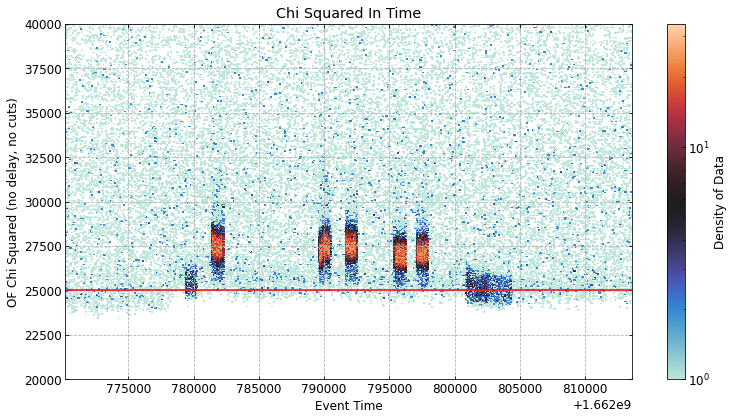

In [24]:
fig, ax = dp.densityplot(
    df_nos.eventtime,
    df_nos.ofchi2_nodelay_CPDv21Ge,
    cut=ctrigger_nos,
    ylims=[0.2e5, 4e4],
  #  xlims=[0, 1.2],
)
#number of dof per trace (chi2 mean)
ax.axhline((fs*tracelength),c='r')
ax.set_xlabel('Event Time')
ax.set_ylabel('OF Chi Squared (no delay, no cuts)')
ax.set_title('Chi Squared In Time')
fig.tight_layout()

'''
fig.savefig(
'/data/users/da_real_maggie_reed/analysis/run_20/figs/run20_goodtime_postc.png',
dpi=500,
facecolor='none',
)
#''';

In [25]:
#defining our times

ctime_mid_1 = ((df_nos.eventtime>781250+1.662e9)&(df_nos.eventtime<782500+1.662e9))
ctime_mid_2 = ((df_nos.eventtime>789600+1.662e9)&(df_nos.eventtime<790630+1.662e9))
ctime_mid_3 = ((df_nos.eventtime>791700+1.662e9)&(df_nos.eventtime<792700+1.662e9))
ctime_mid_4 = ((df_nos.eventtime>795300+1.662e9)&(df_nos.eventtime<798000+1.662e9))
ctime_mid_5 = ((df_nos.eventtime>800900+1.662e9)&(df_nos.eventtime<804500+1.662e9))
ctime_mid_6 = ((df_nos.eventtime>779200+1.662e9)&(df_nos.eventtime<780300+1.662e9))
cgoodtime_nos = (np.invert(ctime_mid_1) & np.invert(ctime_mid_2) & np.invert(ctime_mid_3) 
             & np.invert(ctime_mid_4) & np.invert(ctime_mid_5) & np.invert(ctime_mid_6))


### Ba cut

In [26]:
#defining our times
ctime_mid_1 = ((df_Ba.eventtime>671000+1.662e9)&(df_Ba.eventtime<673000+1.662e9))
ctime_mid_2 = ((df_Ba.eventtime>680400+1.662e9)&(df_Ba.eventtime<681400+1.662e9))
ctime_mid_3 = ((df_Ba.eventtime>682000+1.662e9)&(df_Ba.eventtime<683200+1.662e9))
ctime_mid_4 = ((df_Ba.eventtime>685900+1.662e9)&(df_Ba.eventtime<686900+1.662e9))
ctime_mid_5 = ((df_Ba.eventtime>708500+1.662e9)&(df_Ba.eventtime<709000+1.662e9))
cgoodtime_Ba = (np.invert(ctime_mid_1) & np.invert(ctime_mid_2) & np.invert(ctime_mid_3) & np.invert(ctime_mid_4)
            & np.invert(ctime_mid_5))


### Co cut

In [27]:
ctime_mid_1 = ((df_Co.eventtime>23600+1.6631e9)&(df_Co.eventtime<24600+1.6631e9))
ctime_mid_2 = ((df_Co.eventtime>26500+1.6631e9)&(df_Co.eventtime<27500+1.6631e9))
ctime_mid_3 = ((df_Co.eventtime>28500+1.6631e9)&(df_Co.eventtime<29500+1.6631e9))
ctime_mid_4 = ((df_Co.eventtime>38200+1.6631e9)&(df_Co.eventtime<39200+1.6631e9))
ctime_mid_5 = ((df_Co.eventtime>39800+1.6631e9)&(df_Co.eventtime<40900+1.6631e9))
cgoodtime_Co = (np.invert(ctime_mid_1) & np.invert(ctime_mid_2) & np.invert(ctime_mid_3) & 
             np.invert(ctime_mid_4) & np.invert(ctime_mid_5))

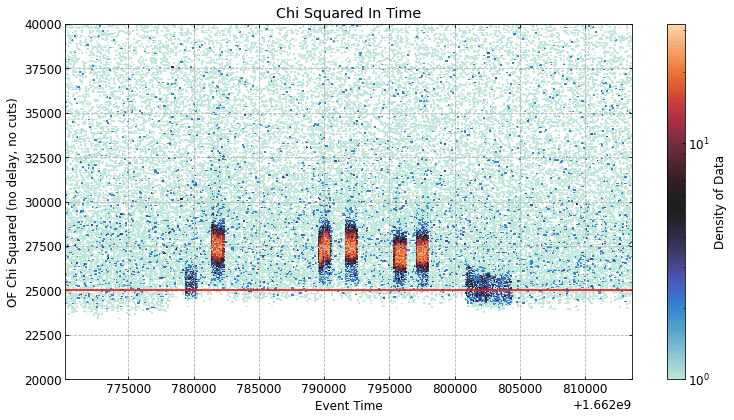

In [5]:
fig, ax = dp.densityplot(
    df_nos.eventtime,
    df_nos.ofchi2_constrained_CPDv21Ge,
    cut=ctrigger_nos,
    ylims=[0.2e5, 4e4],
  #  xlims=[0, 1.2],
)
#number of dof per trace (chi2 mean)
ax.axhline((fs*tracelength),c='r')
ax.set_xlabel('Event Time')
ax.set_ylabel('OF Chi Squared (no delay, no cuts)')
ax.set_title('Chi Squared In Time')
fig.tight_layout()

'''
fig.savefig(
'/data/users/da_real_maggie_reed/analysis/run_20/figs/run20_goodtime_postc.png',
dpi=500,
facecolor='none',
)
#''';

In [8]:
#events_upper = sum(ctemp_up[ctrigger&cgood_time])/tot_time

#print('the rate of events in the lower distribution is:',events_lower,'\n')


### no Ba cut

In [28]:
cgoodtime_noBa = ((df_noBa.eventtime>504000+1.659e9)&(df_noBa.eventtime<513000+1.659e9))


### r19 Ba cut

In [5]:
cgoodtime_r19Ba = (dp.inrange(df_r19Ba.eventtime,20000+1.6594e9,30000+1.6594e9))


# Baseline cut

### No source baseline cut

In [29]:
#more rigorous baseline cut
#binning the event time into 400s bins and then finding baseline cut that cuts 10% of high end of baseline in each bin
import math
start_time=df_nos.eventtime[ctrigger_nos].iloc[0]
binsize=400 #size in seconds of each bin used to partition eventtime for baseline cutting
binnumber=tot_runtime_nos/binsize

cbaseline_list=np.empty(math.ceil(binnumber),dtype='object')

for i in range(math.floor(binnumber)):
    ctime_temp = dp.inrange(df_nos.eventtime,(binsize*i)+start_time,(binsize*(i+1))+start_time)
    cut_value=np.percentile(df_nos.baseline_CPDv21Ge[ctime_temp],70)
    cbaseline_list[i]=dp.inrange(df_nos.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

if math.floor(binnumber)!=math.ceil(binnumber): #this fills in the cut for the last time bin, which isn't the full length of the other time bins unless your bin size perfectly divides your total time 
    ctime_temp=dp.inrange(df_nos.eventtime,(binsize*math.floor(binnumber))+start_time,start_time+tot_runtime_nos)
    cut_value=np.percentile(df_nos.baseline_CPDv21Ge[ctime_temp],70)
    cbaseline_list[-1]=dp.inrange(df_nos.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

In [30]:
#more rigorous baseline cut
cbaseline_nos=cbaseline_list[0]
for i in range(len(cbaseline_list)):
    cbaseline_nos=cbaseline_nos|cbaseline_list[i] #this takes all the baseline cuts from the previous step and bitwise ORs them into one cut


In [303]:
#more rigorous baseline cut
#binning the event time into 400s bins and then finding baseline cut that cuts 10% of high end of baseline in each bin
import math
start_time=df_nos.eventtime[ctrigger_nos].iloc[0]
binsize=400 #size in seconds of each bin used to partition eventtime for baseline cutting
binnumber=tot_runtime_nos/binsize

cbaseline_list2=np.empty(math.ceil(binnumber),dtype='object')

for i in range(math.floor(binnumber)):
    ctime_temp = dp.inrange(df_nos.eventtime,(binsize*i)+start_time,(binsize*(i+1))+start_time)
    cut_value=np.percentile(df_nos.baseline_CPDv21Ge[ctime_temp],90)
    cbaseline_list2[i]=dp.inrange(df_nos.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

if math.floor(binnumber)!=math.ceil(binnumber): #this fills in the cut for the last time bin, which isn't the full length of the other time bins unless your bin size perfectly divides your total time 
    ctime_temp=dp.inrange(df_nos.eventtime,(binsize*math.floor(binnumber))+start_time,start_time+tot_runtime_nos)
    cut_value=np.percentile(df_nos.baseline_CPDv21Ge[ctime_temp],90)
    cbaseline_list2[-1]=dp.inrange(df_nos.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

In [304]:
#more rigorous baseline cut
cbaseline_nos2=cbaseline_list2[0]
for i in range(len(cbaseline_list2)):
    cbaseline_nos2=cbaseline_nos2|cbaseline_list2[i] #this takes all the baseline cuts from the previous step and bitwise ORs them into one cut


##### Checking baseline distribution for some time slice

In [214]:
start_time=df_nos.eventtime[ctrigger_nos].iloc[0]
start_time

1662770169.3152857

1433157.5326759918 1/V
0.009577728756379111


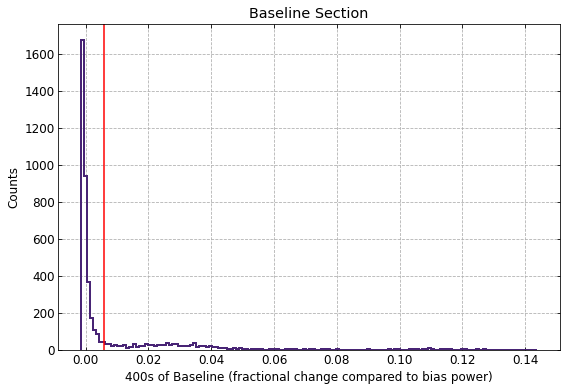

In [293]:
# checking baseline gaussian distribution for tail location to confirm percentage choice
# looking at scale in fractional change to bias power
#-1/i0[A]*(Rsh[Ohms]-R0[Ohms]
start_time=df_nos.eventtime[ctrigger_nos].iloc[0]
dIdP_zero = -1/(11.2e-6*((4+5)*1e-3-71.3e-3))#1/V
P0  =  9.44e-12
print(dIdP_zero, "1/V")
i=4
binsize1 = 400
ctime_temp_plotting = dp.inrange(df_nos.eventtime,(binsize1*i)+start_time,(binsize1*(i+1))+start_time)
cut_value_plotting=np.percentile(df_nos.baseline_CPDv21Ge[ctime_temp_plotting],70)
fig, ax = dp.hist(
    (df_nos.baseline_CPDv21Ge+2.95e-6)/dIdP_zero/P0,
    cuts=ctime_temp_plotting,
    lgcrawdata=False,
    #xlims=(-0.04e-6/dIdP_zero/P0,0.05e-6/dIdP_zero/P0),
    labeldict = {'title' : 'Baseline Section',
                'xlabel' : '400s of Baseline (fractional change compared to bias power)',
                'ylabel' : 'Counts',
                },
    lgclegend=False,
    nbins=150
)
ax.set_yscale('linear')
ax.axvline((cut_value_plotting+2.95e-6)/dIdP_zero/P0,color='red')
print((cut_value_plotting+3e-6)/dIdP_zero/P0)

### Co baseline cut

In [31]:
#more rigorous baseline cut
#binning the event time into 400s bins and then finding baseline cut that cuts 10% of high end of baseline in each bin
import math
start_time=df_Co.eventtime[ctrigger_Co].iloc[0]
binsize=400 #size in seconds of each bin used to partition eventtime for baseline cutting
binnumber=tot_runtime_Co/binsize

cbaseline_list=np.empty(math.ceil(binnumber),dtype='object')

for i in range(math.floor(binnumber)):
    ctime_temp = dp.inrange(df_Co.eventtime,(binsize*i)+start_time,(binsize*(i+1))+start_time)
    cut_value=np.percentile(df_Co.baseline_CPDv21Ge[ctime_temp],90)
    cbaseline_list[i]=dp.inrange(df_Co.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

if math.floor(binnumber)!=math.ceil(binnumber): #this fills in the cut for the last time bin, which isn't the full length of the other time bins unless your bin size perfectly divides your total time 
    ctime_temp=dp.inrange(df_Co.eventtime,(binsize*math.floor(binnumber))+start_time,start_time+tot_runtime_Co)
    cut_value=np.percentile(df_Co.baseline_CPDv21Ge[ctime_temp],90)
    cbaseline_list[-1]=dp.inrange(df_Co.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

In [32]:
#more rigorous baseline cut
cbaseline_Co=cbaseline_list[0]
for i in range(len(cbaseline_list)):
    cbaseline_Co=cbaseline_Co|cbaseline_list[i] #this takes all the baseline cuts from the previous step and bitwise ORs them into one cut


##### Distribution

1433157.5326759918 1/V
-0.21433367559898817


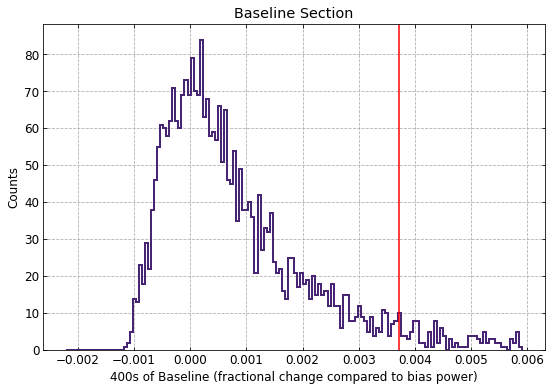

In [289]:
# checking baseline gaussian distribution for tail location to confirm percentage choice
# looking at scale in fractional change to bias power
#-1/i0[A]*(Rsh[Ohms]-R0[Ohms]
start_time=df_Co.eventtime[ctrigger_Co].iloc[0]
dIdP_zero = -1/(11.2e-6*((4+5)*1e-3-71.3e-3))#1/V
P0  =  9.44e-12
print(dIdP_zero, "1/V")
i=4
binsize1 = 400
ctime_temp_plotting = dp.inrange(df_Co.eventtime,(binsize1*i)+start_time,(binsize1*(i+1))+start_time)
cut_value_plotting=np.percentile(df_Co.baseline_CPDv21Ge[ctime_temp_plotting],90)
fig, ax = dp.hist(
    (df_Co.baseline_CPDv21Ge+2.95e-6)/dIdP_zero/P0,
    cuts=ctime_temp_plotting,
    lgcrawdata=False,
    xlims=(-0.03e-6/dIdP_zero/P0,0.08e-6/dIdP_zero/P0),
    labeldict = {'title' : 'Baseline Section',
                'xlabel' : '400s of Baseline (fractional change compared to bias power)',
                'ylabel' : 'Counts',
                },
    lgclegend=False,
    nbins=150
)
ax.set_yscale('linear')
ax.axvline((cut_value_plotting+2.95e-6)/dIdP_zero/P0,color='red')
print((cut_value_plotting)/dIdP_zero/P0)

### Ba baseline cut

In [33]:
#more rigorous baseline cut
#binning the event time into 400s bins and then finding baseline cut that cuts 10% of high end of baseline in each bin
import math
start_time=df_Ba.eventtime[ctrigger_Ba].iloc[0]
binsize=400 #size in seconds of each bin used to partition eventtime for baseline cutting
binnumber=tot_runtime_Ba/binsize

cbaseline_list=np.empty(math.ceil(binnumber),dtype='object')

for i in range(math.floor(binnumber)):
    ctime_temp = dp.inrange(df_Ba.eventtime,(binsize*i)+start_time,(binsize*(i+1))+start_time)
    cut_value=np.percentile(df_Ba.baseline_CPDv21Ge[ctime_temp],90)
    cbaseline_list[i]=dp.inrange(df_Ba.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

if math.floor(binnumber)!=math.ceil(binnumber): #this fills in the cut for the last time bin, which isn't the full length of the other time bins unless your bin size perfectly divides your total time 
    ctime_temp=dp.inrange(df_Ba.eventtime,(binsize*math.floor(binnumber))+start_time,start_time+tot_runtime_Ba)
    cut_value=np.percentile(df_Ba.baseline_CPDv21Ge[ctime_temp],90)
    cbaseline_list[-1]=dp.inrange(df_Ba.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

In [34]:
#more rigorous baseline cut
cbaseline_Ba=cbaseline_list[0]
for i in range(len(cbaseline_list)):
    cbaseline_Ba=cbaseline_Ba|cbaseline_list[i] #this takes all the baseline cuts from the previous step and bitwise ORs them into one cut


Text(0.5, 1.0, 'Baseline Cut')

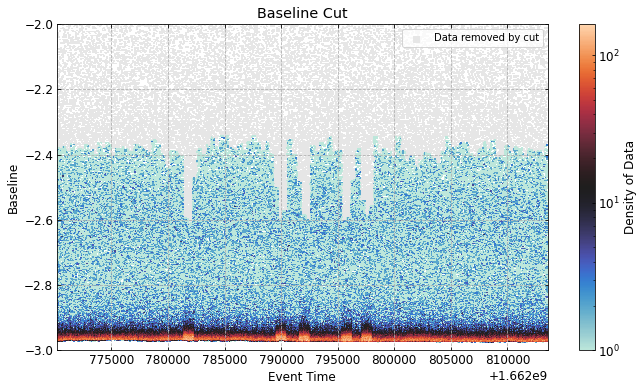

In [16]:
fig, ax = dp.densityplot(
    df_nos.eventtime,
    df_nos.baseline_CPDv21Ge*1e6,
    cut=cbaseline_nos,
    ylims=(-3,-2),
    plot_cut_data = True
    )
ax.set_xlabel('Event Time')
ax.set_ylabel('Baseline')
ax.set_title('Baseline Cut')

##### Distribution

1433157.5326759918 1/V
0.0021339955527415015


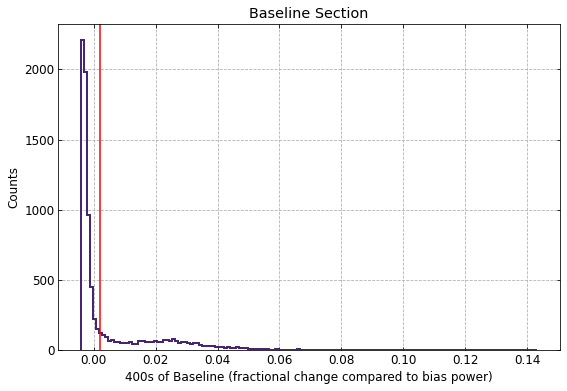

In [297]:
# checking baseline gaussian distribution for tail location to confirm percentage choice
# looking at scale in fractional change to bias power
#-1/i0[A]*(Rsh[Ohms]-R0[Ohms]
start_time=df_Ba.eventtime[ctrigger_Ba].iloc[0]
dIdP_zero = -1/(11.2e-6*((4+5)*1e-3-71.3e-3))#1/V
P0  =  9.44e-12
print(dIdP_zero, "1/V")
i=4
binsize1 = 400
ctime_temp_plotting = dp.inrange(df_Ba.eventtime,(binsize1*i)+start_time,(binsize1*(i+1))+start_time)
cut_value_plotting=np.percentile(df_Ba.baseline_CPDv21Ge[ctime_temp_plotting],70)
fig, ax = dp.hist(
    (df_Ba.baseline_CPDv21Ge+2.95e-6)/dIdP_zero/P0,
    cuts=ctime_temp_plotting,
    lgcrawdata=False,
    #xlims=(-0.04e-6/dIdP_zero/P0,0.05e-6/dIdP_zero/P0),
    labeldict = {'title' : 'Baseline Section',
                'xlabel' : '400s of Baseline (fractional change compared to bias power)',
                'ylabel' : 'Counts',
                },
    lgclegend=False,
    nbins=150
)
ax.set_yscale('linear')
ax.axvline((cut_value_plotting+2.95e-6)/dIdP_zero/P0,color='red')
print((cut_value_plotting+2.95e-6)/dIdP_zero/P0)

### No Ba

In [35]:
#more rigorous baseline cut
#binning the event time into 400s bins and then finding baseline cut that cuts 10% of high end of baseline in each bin
import math
start_time=df_noBa.eventtime[ctrigger_noBa].iloc[0]
binsize=400 #size in seconds of each bin used to partition eventtime for baseline cutting
binnumber=tot_runtime_noBa/binsize

cbaseline_list_noBa=np.empty(math.ceil(binnumber),dtype='object')

for i in range(math.floor(binnumber)):
    ctime_temp = dp.inrange(df_noBa.eventtime,(binsize*i)+start_time,(binsize*(i+1))+start_time)
    cut_value=np.percentile(df_noBa.baseline_CPDv21Ge[ctime_temp],85)
    cbaseline_list_noBa[i]=dp.inrange(df_noBa.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

if math.floor(binnumber)!=math.ceil(binnumber): #this fills in the cut for the last time bin, which isn't the full length of the other time bins unless your bin size perfectly divides your total time 
    ctime_temp=dp.inrange(df_noBa.eventtime,(binsize*math.floor(binnumber))+start_time,start_time+tot_runtime_noBa)
    cut_value=np.percentile(df_noBa.baseline_CPDv21Ge[ctime_temp],85)
    cbaseline_list_noBa[-1]=dp.inrange(df_noBa.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

In [36]:
#more rigorous baseline cut
cbaseline_noBa=cbaseline_list_noBa[0]
for i in range(len(cbaseline_list_noBa)):
    cbaseline_noBa=cbaseline_noBa|cbaseline_list_noBa[i] #this takes all the baseline cuts from the previous step and bitwise ORs them into one cut


### r19 Ba cut

In [6]:
start_time=df_r19Ba.eventtime[ctrigger_r19Ba].iloc[0]
binsize=400 #size in seconds of each bin used to partition eventtime for baseline cutting
binnumber=tot_runtime_r19Ba/binsize

cbaseline_list_r19Ba=np.empty(math.ceil(binnumber),dtype='object')

for i in range(math.floor(binnumber)):
    ctime_temp = dp.inrange(df_r19Ba.eventtime,(binsize*i)+start_time,(binsize*(i+1))+start_time)
    cut_value=np.percentile(df_r19Ba.baseline_CPDv21Ge[ctime_temp],85)
    cbaseline_list_r19Ba[i]=dp.inrange(df_r19Ba.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

if math.floor(binnumber)!=math.ceil(binnumber): #this fills in the cut for the last time bin, which isn't the full length of the other time bins unless your bin size perfectly divides your total time 
    ctime_temp=dp.inrange(df_r19Ba.eventtime,(binsize*math.floor(binnumber))+start_time,start_time+tot_runtime_r19Ba)
    cut_value=np.percentile(df_r19Ba.baseline_CPDv21Ge[ctime_temp],85)
    cbaseline_list_r19Ba[-1]=dp.inrange(df_r19Ba.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

In [7]:
#more rigorous baseline cut
cbaseline_r19Ba=cbaseline_list_r19Ba[0]
for i in range(len(cbaseline_list_r19Ba)):
    cbaseline_r19Ba=cbaseline_r19Ba|cbaseline_list_r19Ba[i] #this takes all the baseline cuts from the previous step and bitwise ORs them into one cut


#### Distribution check

1424598.832968636 1/V
0.14166793543248654


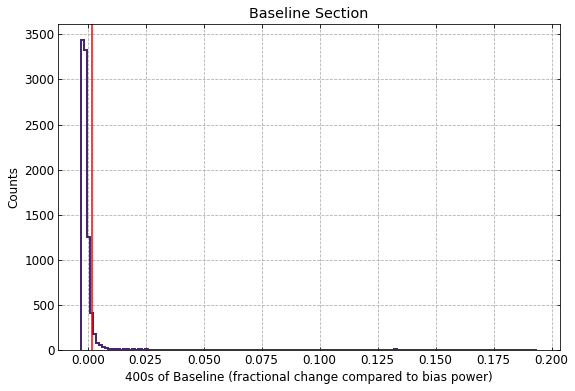

In [13]:
#-1/i0[A]*(Rsh[Ohms]-R0[Ohms]
start_time=df_r19Ba.eventtime[ctrigger_r19Ba].iloc[0]
dIdP_zero = -1/(10.968e-6*((4+5)*1e-3-73.0e-3))#1/V
P0  =  8.78e-12
print(dIdP_zero, "1/V")
i=4
binsize1 = 400
ctime_temp_plotting = dp.inrange(df_r19Ba.eventtime,(binsize1*i)+start_time,(binsize1*(i+1))+start_time)
cut_value_plotting=np.percentile(df_r19Ba.baseline_CPDv21Ge[ctime_temp_plotting],90)
fig, ax = dp.hist(
    (df_r19Ba.baseline_CPDv21Ge+1.25e-6)/dIdP_zero/P0,
    cuts=ctime_temp_plotting,
    lgcrawdata=False,
    #xlims=(-0.04e-6/dIdP_zero/P0,0.05e-6/dIdP_zero/P0),
    labeldict = {'title' : 'Baseline Section',
                'xlabel' : '400s of Baseline (fractional change compared to bias power)',
                'ylabel' : 'Counts',
                },
    lgclegend=False,
    nbins=150
)
ax.set_yscale('linear')
ax.axvline((cut_value_plotting+1.25e-6)/dIdP_zero/P0,color='red')
print((cut_value_plotting+3e-6)/dIdP_zero/P0)

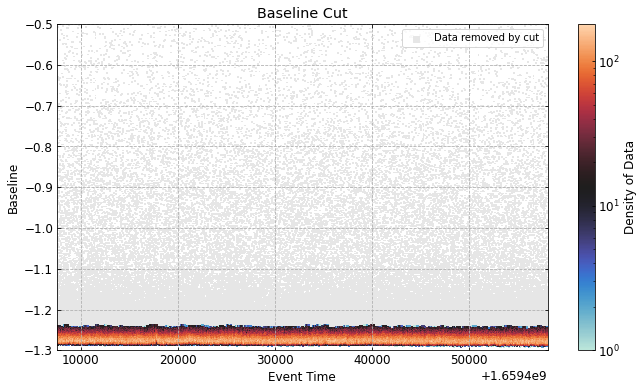

In [15]:
fig, ax = dp.densityplot(
    df_r19Ba.eventtime,
    df_r19Ba.baseline_CPDv21Ge*1e6,
    cut=cbaseline_r19Ba,
    ylims=(-1.3,-0.5),
    plot_cut_data = True
    )
ax.set_xlabel('Event Time')
ax.set_ylabel('Baseline')
ax.set_title('Baseline Cut')
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/run20_baseline_postc.png',dpi=500,
    facecolor='none',
)
#''';

# Energy dependent Chi2 cut

### No source cut

In [37]:
m_strict = 80
b_strict = 27200

m_loose = 45
b_loose = 35000 

m_loose2 = 1000
b_loose2 = 0.2e6

temp_func = lambda x, m, b: m * x**2 + b
temp_func2 = lambda x, m, b: m * (x-60)**2 + b
#ctemp_strict = (((df.ofchi2_unconstrained_CPDv21Ge < temp_func(calibratedofamp_uncon, m_strict, b_strict)))&
#            dp.inrange(calibratedofamp_uncon,0,37))


In [38]:
#keeping everything above 120 kev
conetwentyup_nos = dp.inrange(calibratedofamp_nos_constrained,120,np.inf)
cchi2_strict_nos = (((df_nos.ofchi2_constrained_CPDv21Ge < temp_func(calibratedofamp_nos_constrained,
                                                             m_strict, b_strict)))&
            dp.inrange(calibratedofamp_nos_constrained,-np.inf,20))
cchi2_strict2_nos = (((df_nos.ofchi2_constrained_CPDv21Ge < temp_func(calibratedofamp_nos_constrained,
                                                             m_loose, b_loose)))&
            dp.inrange(calibratedofamp_nos_constrained,20,60))
cchi2_strict3_nos = (((df_nos.ofchi2_constrained_CPDv21Ge < temp_func2(calibratedofamp_nos_constrained,
                                                             m_loose2, b_loose2)))&
            dp.inrange(calibratedofamp_nos_constrained,60,120))
cchi2_temp_nos = ((cchi2_strict_nos | cchi2_strict2_nos | cchi2_strict3_nos) | conetwentyup_nos)
ctemp_weirdpop = dp.inrange(calibratedofamp_nos_constrained,0,0.48)&dp.inrange(calibratedenergy_nos,0.28,0.75)
c_sqglitch_nos = np.invert(ctemp_weirdpop)

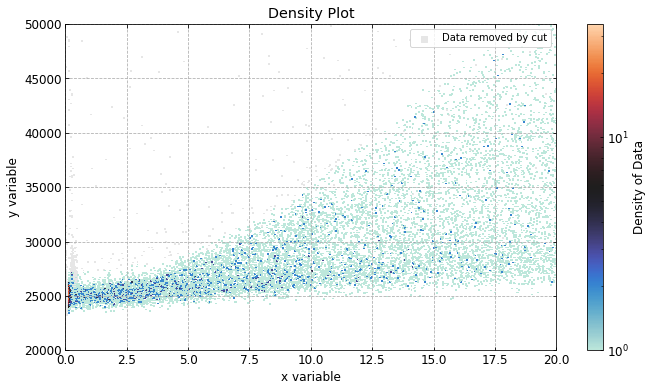

In [77]:
fig, ax = dp.densityplot(
    calibratedofamp_nos_constrained,
    df_nos.ofchi2_constrained_CPDv21Ge,
    cut=ctrigger_nos&cgoodtime_nos&cbaseline_nos&cchi2_temp_nos&c_sqglitch_nos,
    ylims=[2e4, 5e4],
    xlims=[0, 20],
    plot_cut_data = True,
    basecut = cgoodtime_nos,
)

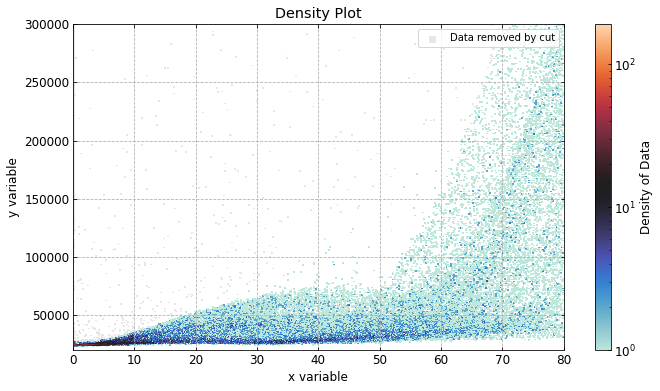

In [305]:
fig, ax = dp.densityplot(
    calibratedofamp_nos_constrained,
    df_nos.ofchi2_constrained_CPDv21Ge,
    cut=ctrigger_nos&cbaseline_nos2&cgoodtime_nos&cchi2_temp_nos,
    ylims=[2e4, 3e5],
    xlims=[0, 80],
    plot_cut_data = True,
    basecut = ctrigger_nos&cgoodtime_nos,
)

### Ba Cut

In [39]:
m_strict = 80
b_strict = 27200

m_loose = 35
b_loose = 36000 

m_loose2 = 1250
b_loose2 = 0.18e6

In [40]:
#keeping everything above 100 kev
conehundup_Ba = dp.inrange(calibratedofamp_Ba_constrained,100,np.inf)
#csixty_110 = dp.inrange(calibratedofamp_constrained,60,110)
cchi2_strict_Ba = (((df_Ba.ofchi2_constrained_CPDv21Ge < temp_func(calibratedofamp_Ba_constrained,
                                                             m_strict, b_strict)))&
            dp.inrange(calibratedofamp_Ba_constrained,-np.inf,20))
cchi2_strict2_Ba = (((df_Ba.ofchi2_constrained_CPDv21Ge < temp_func(calibratedofamp_Ba_constrained,
                                                             m_loose, b_loose)))&
            dp.inrange(calibratedofamp_Ba_constrained,20,60))
cchi2_strict3_Ba = (((df_Ba.ofchi2_constrained_CPDv21Ge < temp_func2(calibratedofamp_Ba_constrained,
                                                             m_loose2, b_loose2)))&
            dp.inrange(calibratedofamp_Ba_constrained,60,100))
cchi2_temp_Ba = ((cchi2_strict_Ba | cchi2_strict2_Ba | cchi2_strict3_Ba) | conehundup_Ba)

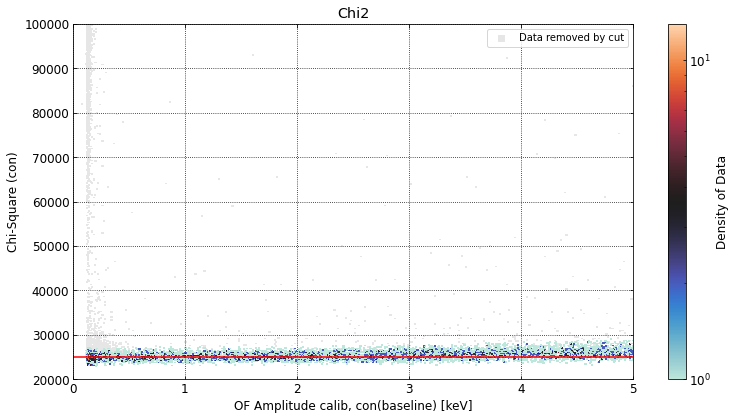

In [51]:
fig, ax = dp.densityplot(
    calibratedofamp_Ba_constrained,
    df_Ba.ofchi2_constrained_CPDv21Ge,
    cut=ctrigger_Ba&cgoodtime_Ba&cbaseline_Ba&cchi2_temp_Ba,
    ylims=[2e4, 1e5],
    xlims=[0, 5],
    plot_cut_data = True,
    basecut = ctrigger_Ba,
)

ax.set_title('Chi2')
ax.set_ylabel(r'Chi-Square (con)')
ax.set_xlabel(r'OF Amplitude calib, con(baseline) [keV]')
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k', zorder=10)

ax.axhline((fs*tracelength),c='r')

fig.tight_layout()
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/.png',
    dpi=500,
    facecolor='none',
    )
#''';

### Co Cut

In [41]:
m_strict = 80
b_strict = 27200

m_loose = 40
b_loose = 35000 

m_loose2 = 990
b_loose2 = 0.17e6


In [42]:
#keeping everything above 100 kev
conehundup_Co = dp.inrange(calibratedofamp_Co_constrained,100,np.inf)
#csixty_110 = dp.inrange(calibratedofamp_constrained,60,110)
cchi2_strict_Co = (((df_Co.ofchi2_constrained_CPDv21Ge < temp_func(calibratedofamp_Co_constrained,
                                                             m_strict, b_strict)))&
            dp.inrange(calibratedofamp_Co_constrained,-np.inf,20))
cchi2_strict2_Co = (((df_Co.ofchi2_constrained_CPDv21Ge < temp_func(calibratedofamp_Co_constrained,
                                                             m_loose, b_loose)))&
            dp.inrange(calibratedofamp_Co_constrained,20,60))
cchi2_strict3_Co = (((df_Co.ofchi2_constrained_CPDv21Ge < temp_func2(calibratedofamp_Co_constrained,
                                                             m_loose2, b_loose2)))&
            dp.inrange(calibratedofamp_Co_constrained,60,100))
cchi2_temp_Co = ((cchi2_strict_Co | cchi2_strict2_Co | cchi2_strict3_Co) | conehundup_Co)

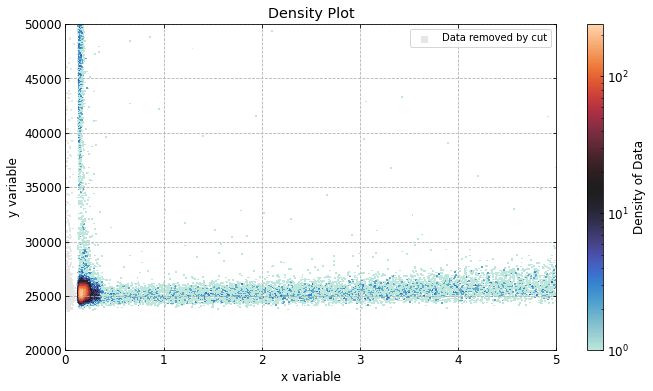

In [13]:
fig, ax = dp.densityplot(
    calibratedofamp_Co_constrained,
    df_Co.ofchi2_constrained_CPDv21Ge,
    cut=ctrigger_Co,
    ylims=[2e4, 5e4],
    xlims=[0, 5],
    plot_cut_data = True,
    #basecut = cgoodtime_nos,
)

### No Ba

In [43]:
temp_func = lambda x, m, b: m * x**2 + b
temp_func2 = lambda x, m, b: m * (x-50)**2 + b
temp_func3 = lambda x, m, b: m * (x-20) + b

m_strict_noBa = 70
b_strict_noBa = 26000

m_loose_noBa = 1e3
b_loose_noBa = 54000 

m_loose2_noBa = 900
b_loose2_noBa = 90000

In [44]:
#keeping everything above 110 kev
conetwentyup_noBa = dp.inrange(calibratedofamp_noBa_constrained,120,np.inf)
#csixty_110 = dp.inrange(calibratedofamp_constrained,60,110)
cchi2_strict_noBa = (((df_noBa.ofchi2_constrained_CPDv21Ge < temp_func(calibratedofamp_noBa_constrained,
                                                             m_strict_noBa, b_strict_noBa)))&
            dp.inrange(calibratedofamp_noBa_constrained,-np.inf,20))
cchi2_strict2_noBa = (((df_noBa.ofchi2_constrained_CPDv21Ge < temp_func3(calibratedofamp_noBa_constrained,
                                                             m_loose_noBa, b_loose_noBa)))&
            dp.inrange(calibratedofamp_noBa_constrained,20,50))
cchi2_strict3_noBa = (((df_noBa.ofchi2_constrained_CPDv21Ge < temp_func2(calibratedofamp_noBa_constrained,
                                                             m_loose2_noBa, b_loose2_noBa)))&
            dp.inrange(calibratedofamp_noBa_constrained,50,120))
cchi2_temp_noBa = ((cchi2_strict_noBa | cchi2_strict2_noBa | cchi2_strict3_noBa) | conetwentyup_noBa)


### r19 Ba

In [16]:
temp_func = lambda x, m, b: m * x**2 + b
temp_func2 = lambda x, m, b: m * (x-50)**2 + b
temp_func3 = lambda x, m, b: m * (x-20) + b

m_strict = 70
b_strict = 26000

m_loose = 1e3
b_loose = 54000 

m_loose2 = 1200
b_loose2 = 90000

In [18]:
conetwentyup_r19Ba = dp.inrange(calibratedofamp_r19Ba_constrained,100,np.inf)
#csixty_110 = dp.inrange(calibratedofamp_constrained,60,110)
cchi2_strict_r19Ba = (((df_r19Ba.ofchi2_constrained_CPDv21Ge < temp_func(calibratedofamp_r19Ba_constrained,
                                                             m_strict, b_strict)))&
            dp.inrange(calibratedofamp_r19Ba_constrained,-np.inf,20))
cchi2_strict2_r19Ba = (((df_r19Ba.ofchi2_constrained_CPDv21Ge < temp_func3(calibratedofamp_r19Ba_constrained,
                                                             m_loose, b_loose)))&
            dp.inrange(calibratedofamp_r19Ba_constrained,20,50))
cchi2_strict3_r19Ba = (((df_r19Ba.ofchi2_constrained_CPDv21Ge < temp_func2(calibratedofamp_r19Ba_constrained,
                                                             m_loose2, b_loose2)))&
            dp.inrange(calibratedofamp_r19Ba_constrained,50,100))
cchi2_temp_r19Ba = ((cchi2_strict_r19Ba | cchi2_strict2_r19Ba | cchi2_strict3_r19Ba) | conetwentyup_r19Ba)


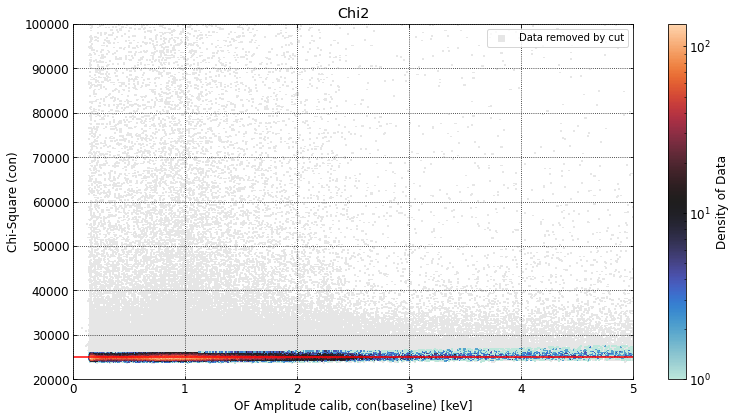

In [24]:
fig, ax = dp.densityplot(
    calibratedofamp_r19Ba_constrained,
    df_r19Ba.ofchi2_constrained_CPDv21Ge,
    cut=ctrigger_r19Ba&cgoodtime_r19Ba&cbaseline_r19Ba&cchi2_temp_r19Ba,
    ylims=[2e4, 1e5],
    xlims=[0, 5],
    plot_cut_data = True,
    basecut = ctrigger_r19Ba,
)

ax.set_title('Chi2')
ax.set_ylabel(r'Chi-Square (con)')
ax.set_xlabel(r'OF Amplitude calib, con(baseline) [keV]')
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k', zorder=10)

ax.axhline((fs*tracelength),c='r')

fig.tight_layout()
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/.png',
    dpi=500,
    facecolor='none',
    )
#''';

# Checking template fit to pulse shape

## Checking to see if the calibrated ofamp and the calibrated energy have a linear relationship
A linear relationship between the two implies that they are calibrated well. 

### No source 

Text(0, 0.5, 'calibrated energy abs')

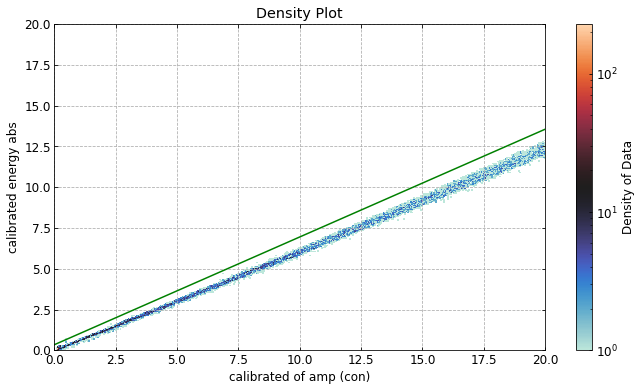

In [75]:
#slightly off from a one to one ratio by a factor of energyabsorbed*1.6
fig, ax = dp.densityplot(
    calibratedofamp_nos_constrained,
    calibratedenergy_nos,
    cut= ctrigger_nos&cgoodtime_nos&cbaseline_nos&cchi2_temp_nos&c_sqglitch_nos,
    xlims=(0,80),
    ylims=(0,80)
   # ylims=(-3.25,-2)
    )
ax.axline((1,1),xy2=(60,40),color='green')
ax.set_xlabel('calibrated of amp (con)')
ax.set_ylabel('calibrated energy abs')

### Ba

In [56]:
cgoodevents_Ba = ctrigger_Ba&cgoodtime_Ba&cbaseline_Ba&cchi2_temp_Ba

Text(0.5, 1.0, 'r20 Ba (no GaAs)')

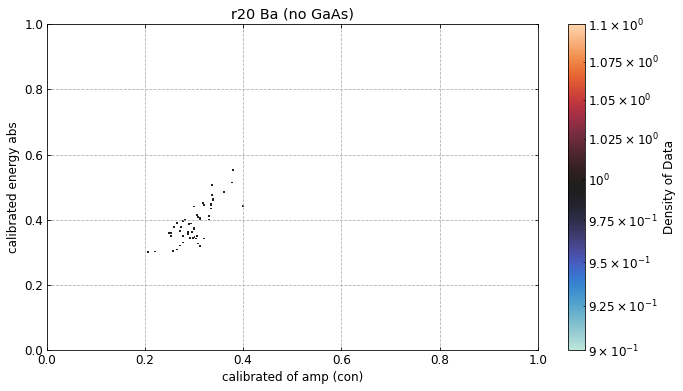

In [57]:
#slightly off from a one to one ratio by a factor of energyabsorbed*1.6
fig, ax = dp.densityplot(
    calibratedofamp_Ba_constrained,
    calibratedenergy_Ba,
    cut= cgoodevents_Ba&ctemp_Ba_lowpop,
    xlims=(0,1),
    ylims=(0,1)
   # ylims=(-3.25,-2)
    )
#ax.axline((1,1),xy2=(60,40),color='green')
ax.set_xlabel('calibrated of amp (con)')
ax.set_ylabel('calibrated energy abs')
ax.set_title('r20 Ba (no GaAs)')

In [53]:
ctemp_Ba_lowpop = (dp.inrange(calibratedofamp_Ba_constrained, 0.2, 0.4) & dp.inrange(calibratedenergy_Ba, 0.3, 0.6))

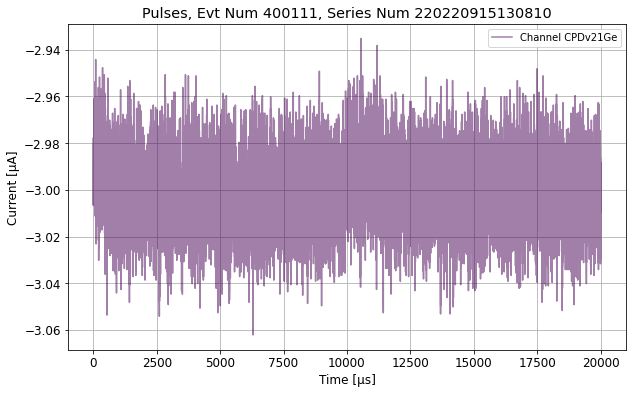

In [58]:
# check the low pop of events for Ba run 20
#grabbing 60-120 traces
trigger_path = '/sdata1/runs/run20/processed/threshtrig_Ba_12hr_I2_D20220914_T151839'
rands = getrandevents(trigger_path,
    df_Ba.eventnumber,
    df_Ba.seriesnumber,                    
    ntraces=10,
    nplot=1,
    channels=['CPDv21Ge'],
    cut=cgoodevents_Ba&ctemp_Ba_lowpop,
    lgcplot=True)

In [59]:
#grabbing the x,t,cut
t = rands[0]
x = rands[1]
cout = rands[2]
lowpassed = qp.utils.lowpassfilter(x)

In [ ]:
#plotting the template used to process vs the lower distribution trace
trace_number=1
for i in range(trace_number):
    plt.plot(t*1e6, x[i,0], color='r',alpha=0.4)

Text(0.5, 1.0, 'r20 low pop Ba')

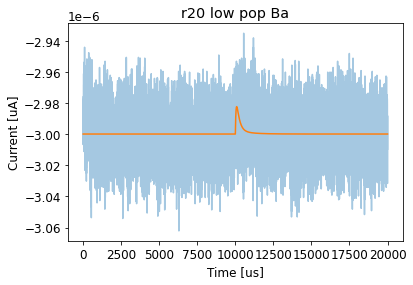

In [62]:
#plotting the template used to process vs the lower distribution trace
trace_number=1
for i in range(trace_number):
    plt.plot(t*1e6, x[i,0], alpha=0.4)
    templaterolled = np.roll(template,int(
        df_Ba.oft0_constrained_CPDv21Ge[cout].iloc[i]*fs))
    plt.plot(t*1e6, (templaterolled*
                     df_Ba.ofamp_constrained_CPDv21Ge[cout].iloc[i])+
             df_Ba.baseline_CPDv21Ge[cout].iloc[i])
plt.xlabel('Time [us]')
plt.ylabel('Current [uA]')
plt.title('r20 low pop Ba')

### Co

Text(0, 0.5, 'calibrated energy abs')

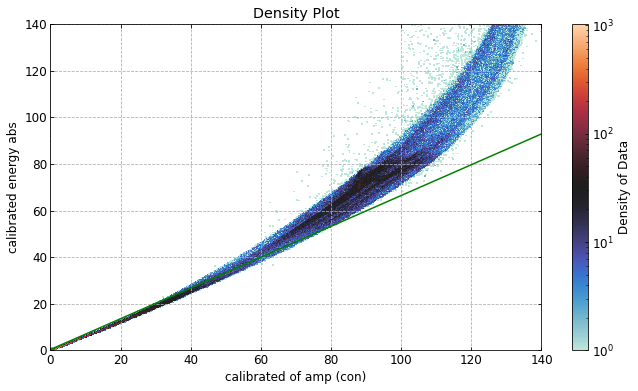

In [39]:
#slightly off from a one to one ratio by a factor of energyabsorbed*1.6
fig, ax = dp.densityplot(
    calibratedofamp_Co_constrained,
    calibratedenergy_Co,
    cut= ctrigger_Co&cgoodtime_Co&cbaseline_Co&cchi2_temp_Co,
    xlims=(0,140),
    ylims=(0,140)
   # ylims=(-3.25,-2)
    )
ax.axline((1,1),xy2=(60,40),color='green')
ax.set_xlabel('calibrated of amp (con)')
ax.set_ylabel('calibrated energy abs')

### No Ba

Text(0.5, 1.0, 'run 19 no Ba (with GaAs)')

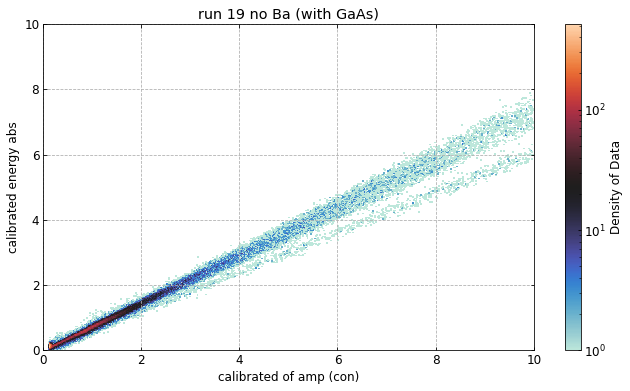

In [108]:
#slightly off from a one to one ratio by a factor of energyabsorbed*1.6
fig, ax = dp.densityplot(
    calibratedofamp_noBa_constrained,
    calibratedenergy_noBa,
    cut= ctrigger_noBa&cgoodtime_noBa&cbaseline_noBa&cchi2_temp_noBa,
    xlims=(0,10),
    ylims=(0,10)
   # ylims=(-3.25,-2)
    )
#ax.plot(x_fitting_strictcalb, y_strict_lin)
#ax.axline((1,1),xy2=(60,40),color='green')
ax.set_xlabel('calibrated of amp (con)')
ax.set_ylabel('calibrated energy abs')
ax.set_title('run 19 no Ba (with GaAs)')

In [112]:
x_fitting_strictcalb = np.arange(2.5,10,0.1)

y_strict_lin = b_splitpop+m_splitpop*(x_fitting_strictcalb-4)
temp_funclin = lambda x, m, b: m * (x-2.5) + b


In [111]:
m_splitpop = 0.70
b_splitpop = 2.7

ctemp_splitpop = (((calibratedenergy_noBa > temp_funclin(calibratedofamp_noBa_constrained,
                                                             m_splitpop, b_splitpop)))&
            dp.inrange(calibratedofamp_noBa_constrained,2.5,10))
'''
ctemp_splitpop2 = (((calibratedenergy < temp_funclin(calibratedofamp_constrained,
                                                             m_splitpop, b_splitpop)))&
            dp.inrange(calibratedofamp_constrained,12,13))  
''';

### r19 Ba

Text(0.5, 1.0, 'run 19 Ba (with GaAs)')

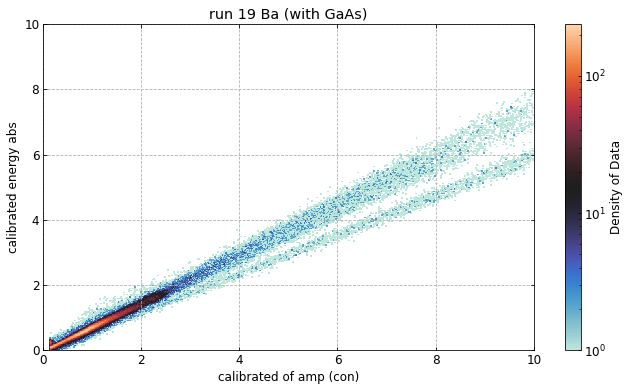

In [107]:
#slightly off from a one to one ratio by a factor of energyabsorbed*1.6
fig, ax = dp.densityplot(
    calibratedofamp_r19Ba_constrained,
    calibratedenergy_r19Ba,
    cut= ctrigger_r19Ba&cgoodtime_r19Ba&cbaseline_r19Ba&cchi2_temp_r19Ba,
    xlims=(0,10),
    ylims=(0,10)
   # ylims=(-3.25,-2)
    )
#ax.plot(x_fitting_strictcalb, y_strict_lin)
#ax.axline((1,1),xy2=(60,40),color='green')
ax.set_xlabel('calibrated of amp (con)')
ax.set_ylabel('calibrated energy abs')
ax.set_title('run 19 Ba (with GaAs)')

# Combined cuts

## Calibrated OFAmp

### No source

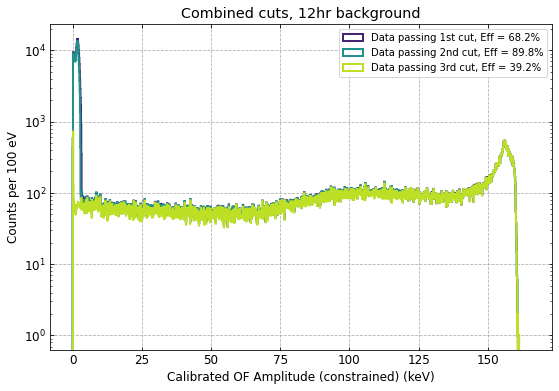

In [40]:

fig, ax = dp.hist(
    calibratedofamp_nos_constrained,
    xlims = (0,165),
    nbins = 1650,
    cuts = [ctrigger_nos&cgoodtime_nos,cbaseline_nos,cchi2_temp_nos&c_sqglitch_nos],
    labeldict = {'title' : 'Combined cuts, 12hr background',
                'xlabel' : 'Calibrated OF Amplitude (constrained) (keV)',
                'ylabel' : 'Counts per 100 eV',
                },
    lgcrawdata=False,
)
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/combcuts_nos_12hr_calibofamp_hist.png',
    dpi=500,
    facecolor='none',
)
#''';

### Ba

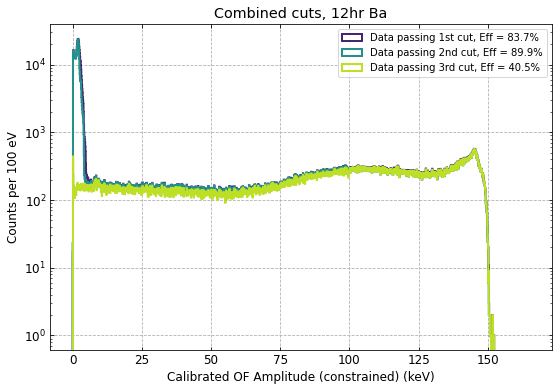

In [41]:
fig, ax = dp.hist(
    calibratedofamp_Ba_constrained,
    xlims = (0,165),
    nbins = 1650,
    cuts = [ctrigger_Ba&cgoodtime_Ba,cbaseline_Ba,cchi2_temp_Ba],
    labeldict = {'title' : 'Combined cuts, 12hr Ba',
                'xlabel' : 'Calibrated OF Amplitude (constrained) (keV)',
                'ylabel' : 'Counts per 100 eV',
                },
    lgcrawdata=False,
)
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/combcuts_nos_12hr_calibofamp_hist.png',
    dpi=500,
    facecolor='none',
)
#''';

### Co

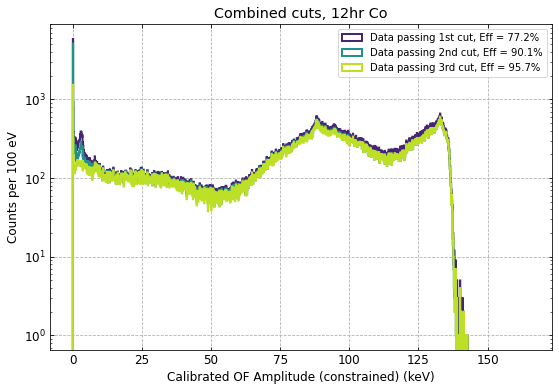

In [42]:
fig, ax = dp.hist(
    calibratedofamp_Co_constrained,
    xlims = (0,165),
    nbins = 1650,
    cuts = [ctrigger_Co&cgoodtime_Co,cbaseline_Co,cchi2_temp_Co],
    labeldict = {'title' : 'Combined cuts, 12hr Co',
                'xlabel' : 'Calibrated OF Amplitude (constrained) (keV)',
                'ylabel' : 'Counts per 100 eV',
                },
    lgcrawdata=False,
)
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/combcuts_nos_12hr_calibofamp_hist.png',
    dpi=500,
    facecolor='none',
)
#''';

### Combined

In [132]:
nos_cut_calofamp = calibratedofamp_nos_constrained[ctrigger_nos&
                                                   cgoodtime_nos&cbaseline_nos&
                                                  cchi2_temp_nos&c_sqglitch_nos]
Ba_cut_calofamp = calibratedofamp_Ba_constrained[ctrigger_Ba&
                                                   cgoodtime_Ba&cbaseline_Ba&
                                                  cchi2_temp_Ba]
Co_cut_calofamp = calibratedofamp_Co_constrained[ctrigger_Co&
                                                   cgoodtime_Co&cbaseline_Co&
                                                  cchi2_temp_Co]

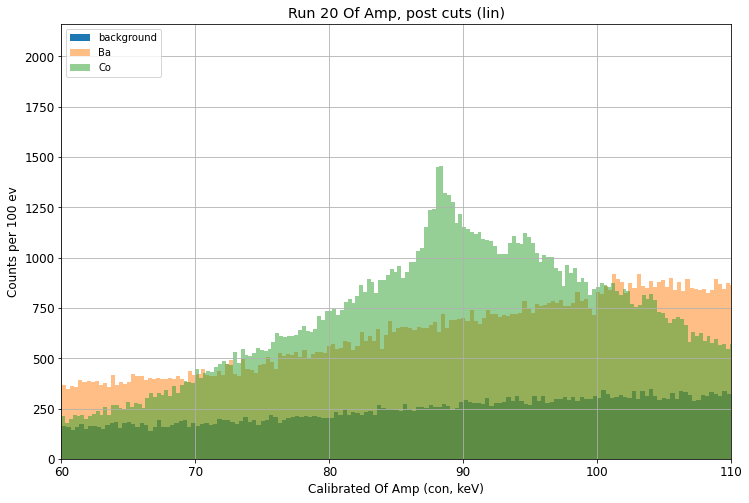

In [152]:
scaling = False
plt.figure(figsize=(12,8))
plt.hist(nos_cut_calofamp,
        bins=500, log=scaling, label='background')
plt.hist(Ba_cut_calofamp,
        bins=500, log=scaling, alpha = 0.5, label='Ba')
plt.hist(Co_cut_calofamp,
        bins=500, log=scaling, alpha = 0.5, label='Co')

plt.xlim(60,110)
#plt.ylim(0,600)
plt.legend(loc="upper left")
plt.title('Run 20 Of Amp, post cuts (lin)')
plt.ylabel('Counts per 100 ev')
plt.xlabel('Calibrated Of Amp (con, keV)')
plt.grid(visible=True)
'''
plt.savefig('/data/users/da_real_maggie_reed/analysis/run_20/figs/all_lin_ofamp_wide3_hist.png',
    dpi=500,
    facecolor='none',)
    #''';
plt.show()

## Calibrated energy absorbed

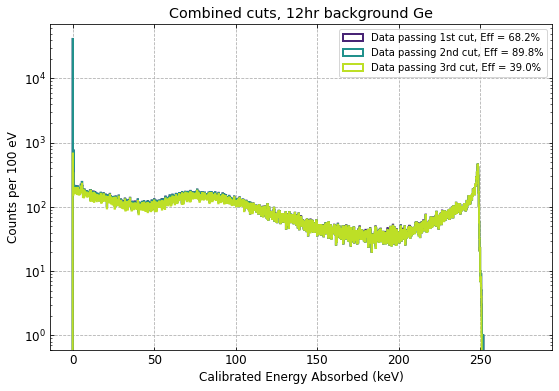

In [388]:

fig, ax = dp.hist(
    calibratedenergy,
    xlims = (0,280),
    nbins = 1700,
    cuts = [ctrigger&cgoodtime,cbaseline,cchi2_temp&c_sqglitch],
    labeldict = {'title' : 'Combined cuts, 12hr background Ge',
                'xlabel' : 'Calibrated Energy Absorbed (keV)',
                'ylabel' : 'Counts per 100 eV',
                },
    lgcrawdata=False,
)
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/all_energabs_wide1_hist.png',
    dpi=500,
    facecolor='none',
)
#''';

### Combined

In [153]:
nos_cut_calenergy = calibratedenergy_nos[ctrigger_nos&
                                                   cgoodtime_nos&cbaseline_nos&
                                                  cchi2_temp_nos&c_sqglitch_nos]
Ba_cut_calenergy = calibratedenergy_Ba[ctrigger_Ba&
                                                   cgoodtime_Ba&cbaseline_Ba&
                                                  cchi2_temp_Ba]
Co_cut_calenergy = calibratedenergy_Co[ctrigger_Co&
                                                   cgoodtime_Co&cbaseline_Co&
                                                  cchi2_temp_Co]

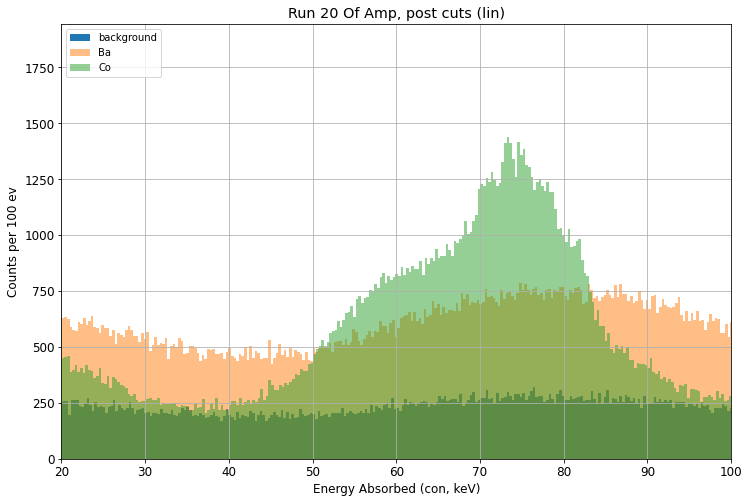

In [158]:
scaling = False
plt.figure(figsize=(12,8))
plt.hist(nos_cut_calenergy,
        bins=800, log=scaling, label='background')
plt.hist(Ba_cut_calenergy,
        bins=800, log=scaling, alpha = 0.5, label='Ba')
plt.hist(Co_cut_calenergy,
        bins=800, log=scaling, alpha = 0.5, label='Co')
plt.xlim(20,100)
plt.legend(loc="upper left")
plt.title('Run 20 Of Amp, post cuts (lin)')
plt.ylabel('Counts per 100 ev')
plt.xlabel('Energy Absorbed (con, keV)')
plt.grid(visible=True)
'''
plt.savefig('/data/users/da_real_maggie_reed/analysis/run_20/figs/allsets_lin_energabs_wide2_hist.png',
    dpi=500,
    facecolor='none',)
    #''';
plt.show()


## Checking true efficiencies in various ranges for comparison between runs

### No source

#### Calibrated ofamp

In [67]:
#ctrigger&cgoodtime,cbaseline,cchi2_temp&c_sqglitch
czerosevenkev_nos=dp.inrange(calibratedofamp_nos_constrained,0,7)
cseven60kev_nos=dp.inrange(calibratedofamp_nos_constrained,7,60)
csixtyonetwntykev_nos = dp.inrange(calibratedofamp_nos_constrained,60,120)
conetwntyupkev_nos = dp.inrange(calibratedofamp_nos_constrained,120,np.inf)
callev_nos = dp.inrange(calibratedofamp_nos_constrained, 0,np.inf)

In [72]:
#cutting efficiency tables calibrated ofamp for 12 hour background
#cbaselinelow,cpresat_low_uncon,ctemplow_strict,cdel_low
#ctemp_low = 
cut_list = [cgoodtime_nos,cbaseline_nos,c_sqglitch_nos,cchi2_temp_nos]
index_list = ['time','baseline','chi2glitch','chi2']
energy_list = [czerosevenkev_nos,cseven60kev_nos,csixtyonetwntykev_nos,conetwntyupkev_nos,callev_nos]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-60 keV",'60-120 keV','120-inf kev','0-inf kev']

cutefficiencies(cut_list,index_list,suffix=calibratedofamp_nos_constrained,
                trigsuffix=ctrigger_nos, randsuffix=crandoms_nos,
                energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-60 keV)- Differential Efficiency,Trigger (7-60 keV)- Total Efficiency,Trigger (60-120 keV)- Differential Efficiency,Trigger (60-120 keV)- Total Efficiency,Trigger (120-inf kev)- Differential Efficiency,Trigger (120-inf kev)- Total Efficiency,Trigger (0-inf kev)- Differential Efficiency,Trigger (0-inf kev)- Total Efficiency
time,0.753600,0.7536,0.664135,0.664135,0.755615,0.755615,0.751814,0.751814,0.754311,0.754311,0.693041,0.693041
baseline,0.984342,0.7418,0.846490,0.562183,0.994830,0.751709,0.994673,0.747809,0.993398,0.749331,0.898321,0.622573
chi2glitch,0.999730,0.7416,0.995485,0.559645,1.000000,0.751709,1.000000,0.747809,1.000000,0.749331,0.997239,0.620854
chi2,0.890642,0.6605,0.023749,0.013291,0.949659,0.713867,0.967162,0.723253,1.000000,0.749331,0.395074,0.245283


In [74]:
ctemp_mask = cbaseline_nos&cchi2_temp_nos&c_sqglitch_nos

In [75]:
randoms_total_eff = 0.66
calc_rate_all = sum(cgoodtime_nos&ctrigger_nos&ctemp_mask)/tot_runtime_nos
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_zeroseven = sum(cgoodtime_nos&ctrigger_nos&ctemp_mask&czerosevenkev_nos)/tot_runtime_nos
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff

calc_rate_sevensixty = sum(cgoodtime_nos&ctrigger_nos&ctemp_mask&cseven60kev_nos)/tot_runtime_nos
true_rate_sevensixty = calc_rate_sevensixty/randoms_total_eff

calc_rate_sixtyonetwnty = sum(cgoodtime_nos&ctrigger_nos&ctemp_mask&csixtyonetwntykev_nos)/tot_runtime_nos
true_rate_sixtyonetwnty = calc_rate_sixtyonetwnty/randoms_total_eff

calc_rate_onetwntyup = sum(cgoodtime_nos&ctrigger_nos&ctemp_mask&conetwntyupkev_nos)/tot_runtime_nos
true_rate_onetwntyup = calc_rate_onetwntyup/randoms_total_eff

In [76]:
print(f'The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'The calculated rate from 7-60 keV is {calc_rate_sevensixty}, the true rate is {true_rate_sevensixty}\n')
print(f'The calculated rate from 60-120 keV is {calc_rate_sixtyonetwnty}, the true rate is {true_rate_sixtyonetwnty}\n')
print(f'The calculated rate from 120-inf keV is {calc_rate_onetwntyup}, the true rate is {true_rate_onetwntyup}\n')
print(f'The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 0-7 keV is 0.11918472820948055, the true rate is 0.18058292152951597

The calculated rate from 7-60 keV is 0.6735526580682666, the true rate is 1.0205343304064645

The calculated rate from 60-120 keV is 1.1065475046383488, the true rate is 1.6765871282399223

The calculated rate from 120-inf keV is 1.3482801172843266, the true rate is 2.04284866255201

The calculated rate from 0-inf keV is 3.2475650082004224, the true rate is 4.920553042727913



#### calibrated energy absorbed 

In [ ]:
#def gettruerates (suffix)

In [95]:
#suffix = '_nos'
#ctrigger&cgoodtime,cbaseline,cchi2_temp&c_sqglitch
czerosevenkev_nos=dp.inrange(calibratedenergy_nos,0,7)
cseven60kev_nos=dp.inrange(calibratedenergy_nos,7,60)
csixtyonetwntykev_nos = dp.inrange(calibratedenergy_nos,60,120)
conetwntyupkev_nos = dp.inrange(calibratedenergy_nos,120,np.inf)
callev_nos = dp.inrange(calibratedenergy_nos, 0,np.inf)

In [96]:
#cutting efficiency tables calibrated ofamp for 12 hour background
#cbaselinelow,cpresat_low_uncon,ctemplow_strict,cdel_low
#ctemp_low = 
cut_list = [cgoodtime_nos,cbaseline_nos,c_sqglitch_nos,cchi2_temp_nos]
index_list = ['time','baseline','chi2glitch','chi2']
energy_list = [czerosevenkev_nos,cseven60kev_nos,csixtyonetwntykev_nos,conetwntyupkev_nos,callev_nos]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-60 keV",'60-120 keV','120-inf kev','0-inf kev']

cutefficiencies(cut_list,index_list,suffix=calibratedenergy_nos,
                trigsuffix=ctrigger_nos, randsuffix=crandoms_nos,
                energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-60 keV)- Differential Efficiency,Trigger (7-60 keV)- Total Efficiency,Trigger (60-120 keV)- Differential Efficiency,Trigger (60-120 keV)- Total Efficiency,Trigger (120-inf kev)- Differential Efficiency,Trigger (120-inf kev)- Total Efficiency,Trigger (0-inf kev)- Differential Efficiency,Trigger (0-inf kev)- Total Efficiency
time,0.753600,0.7536,0.447680,0.447680,0.754370,0.754370,0.751286,0.751286,0.754787,0.754787,0.636540,0.636540
baseline,0.984342,0.7418,0.999382,0.447403,0.994348,0.750107,0.996586,0.748722,0.993704,0.750035,0.996104,0.634060
chi2glitch,0.999730,0.7416,0.980299,0.438589,1.000000,0.750107,1.000000,0.748722,1.000000,0.750035,0.994685,0.630690
chi2,0.890642,0.6605,0.165375,0.072532,0.959225,0.719521,0.974522,0.729646,0.998812,0.749144,0.762344,0.480803


In [97]:
ctemp_mask = cbaseline_nos&cchi2_temp_nos&c_sqglitch_nos

In [98]:
randoms_total_eff = 0.66
calc_rate_all = sum(cgoodtime_nos&ctrigger_nos&ctemp_mask)/tot_runtime_nos
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_zeroseven = sum(cgoodtime_nos&ctrigger_nos&ctemp_mask&czerosevenkev_nos)/tot_runtime_nos
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff

calc_rate_sevensixty = sum(cgoodtime_nos&ctrigger_nos&ctemp_mask&cseven60kev_nos)/tot_runtime_nos
true_rate_sevensixty = calc_rate_sevensixty/randoms_total_eff

calc_rate_sixtyonetwnty = sum(cgoodtime_nos&ctrigger_nos&ctemp_mask&csixtyonetwntykev_nos)/tot_runtime_nos
true_rate_sixtyonetwnty = calc_rate_sixtyonetwnty/randoms_total_eff

calc_rate_onetwntyup = sum(cgoodtime_nos&ctrigger_nos&ctemp_mask&conetwntyupkev_nos)/tot_runtime_nos
true_rate_onetwntyup = calc_rate_onetwntyup/randoms_total_eff

In [99]:
print(f'The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'The calculated rate from 7-60 keV is {calc_rate_sevensixty}, the true rate is {true_rate_sevensixty}\n')
print(f'The calculated rate from 60-120 keV is {calc_rate_sixtyonetwnty}, the true rate is {true_rate_sixtyonetwnty}\n')
print(f'The calculated rate from 120-inf keV is {calc_rate_onetwntyup}, the true rate is {true_rate_onetwntyup}\n')
print(f'The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 0-7 keV is 0.18727712414825606, the true rate is 0.28375321840644857

The calculated rate from 7-60 keV is 0.8941388500539615, the true rate is 1.354755833415093

The calculated rate from 60-120 keV is 1.061720778489209, the true rate is 1.6086678461957713

The calculated rate from 120-inf keV is 1.1038984432266576, the true rate is 1.6725733988282692

The calculated rate from 0-inf keV is 3.2475650082004224, the true rate is 4.920553042727913



### Ba

#### Calibrated ofamp

In [80]:
#ctrigger&cgoodtime,cbaseline,cchi2_temp
czerosevenkev_Ba=dp.inrange(calibratedofamp_Ba_constrained,0,7)
cseven60kev_Ba=dp.inrange(calibratedofamp_Ba_constrained,7,60)
csixtyonetwntykev_Ba = dp.inrange(calibratedofamp_Ba_constrained,60,120)
conetwntyupkev_Ba = dp.inrange(calibratedofamp_Ba_constrained,120,np.inf)
callev_Ba = dp.inrange(calibratedofamp_Ba_constrained, 0,np.inf)

In [81]:
#cutting efficiency tables calibrated ofamp for 12 hour Ba
cut_list = [cgoodtime_Ba,cbaseline_Ba,cchi2_temp_Ba]
index_list = ['time','baseline','chi2']
energy_list = [czerosevenkev_Ba,cseven60kev_Ba,csixtyonetwntykev_Ba,conetwntyupkev_Ba,callev_Ba]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-60 keV",'60-120 keV','120-inf kev','0-inf kev']

cutefficiencies(cut_list,index_list,suffix=calibratedofamp_Ba_constrained,
                trigsuffix=ctrigger_Ba, randsuffix=crandoms_Ba,
                energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-60 keV)- Differential Efficiency,Trigger (7-60 keV)- Total Efficiency,Trigger (60-120 keV)- Differential Efficiency,Trigger (60-120 keV)- Total Efficiency,Trigger (120-inf kev)- Differential Efficiency,Trigger (120-inf kev)- Total Efficiency,Trigger (0-inf kev)- Differential Efficiency,Trigger (0-inf kev)- Total Efficiency
time,0.86850,0.8685,0.832814,0.832814,0.867757,0.867757,0.869374,0.869374,0.868427,0.868427,0.845742,0.845742
baseline,0.96707,0.8399,0.848833,0.706920,0.988083,0.857417,0.985144,0.856458,0.980748,0.851708,0.899113,0.760417
chi2,0.81855,0.6875,0.024583,0.017378,0.914549,0.784149,0.966379,0.827664,1.000000,0.851708,0.404865,0.307866


In [82]:
ctemp_mask = cbaseline_Ba&cchi2_temp_Ba

In [84]:
randoms_total_eff = 0.6875
calc_rate_all = sum(cgoodtime_Ba&ctrigger_Ba&ctemp_mask)/tot_runtime_Ba
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_zeroseven = sum(cgoodtime_Ba&ctrigger_Ba&ctemp_mask&czerosevenkev_Ba)/tot_runtime_Ba
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff

calc_rate_sevensixty = sum(cgoodtime_Ba&ctrigger_Ba&ctemp_mask&cseven60kev_Ba)/tot_runtime_Ba
true_rate_sevensixty = calc_rate_sevensixty/randoms_total_eff

calc_rate_sixtyonetwnty = sum(cgoodtime_Ba&ctrigger_Ba&ctemp_mask&csixtyonetwntykev_Ba)/tot_runtime_Ba
true_rate_sixtyonetwnty = calc_rate_sixtyonetwnty/randoms_total_eff

calc_rate_onetwntyup = sum(cgoodtime_Ba&ctrigger_Ba&ctemp_mask&conetwntyupkev_Ba)/tot_runtime_Ba
true_rate_onetwntyup = calc_rate_onetwntyup/randoms_total_eff

In [85]:
print(f'The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'The calculated rate from 7-60 keV is {calc_rate_sevensixty}, the true rate is {true_rate_sevensixty}\n')
print(f'The calculated rate from 60-120 keV is {calc_rate_sixtyonetwnty}, the true rate is {true_rate_sixtyonetwnty}\n')
print(f'The calculated rate from 120-inf keV is {calc_rate_onetwntyup}, the true rate is {true_rate_onetwntyup}\n')
print(f'The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 0-7 keV is 0.250738882379947, the true rate is 0.3647111016435593

The calculated rate from 7-60 keV is 1.6595900723786294, the true rate is 2.4139491961870974

The calculated rate from 60-120 keV is 3.0367187852515136, the true rate is 4.417045505820384

The calculated rate from 120-inf keV is 1.998608208459418, the true rate is 2.9070664850318804

The calculated rate from 0-inf keV is 6.945655948469508, the true rate is 10.102772288682921



#### Calibrated emergy absorbed 

In [100]:
#ctrigger&cgoodtime,cbaseline,cchi2_temp
czerosevenkev_Ba=dp.inrange(calibratedenergy_Ba,0,7)
cseven60kev_Ba=dp.inrange(calibratedenergy_Ba,7,60)
csixtyonetwntykev_Ba = dp.inrange(calibratedenergy_Ba,60,120)
conetwntyupkev_Ba = dp.inrange(calibratedenergy_Ba,120,np.inf)
callev_Ba = dp.inrange(calibratedenergy_Ba, 0,np.inf)

In [101]:
#cutting efficiency tables calibrated ofamp for 12 hour Ba
cut_list = [cgoodtime_Ba,cbaseline_Ba,cchi2_temp_Ba]
index_list = ['time','baseline','chi2']
energy_list = [czerosevenkev_Ba,cseven60kev_Ba,csixtyonetwntykev_Ba,conetwntyupkev_Ba,callev_Ba]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-60 keV",'60-120 keV','120-inf kev','0-inf kev']

cutefficiencies(cut_list,index_list,suffix=calibratedenergy_Ba,
                trigsuffix=ctrigger_Ba, randsuffix=crandoms_Ba,
                energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-60 keV)- Differential Efficiency,Trigger (7-60 keV)- Total Efficiency,Trigger (60-120 keV)- Differential Efficiency,Trigger (60-120 keV)- Total Efficiency,Trigger (120-inf kev)- Differential Efficiency,Trigger (120-inf kev)- Total Efficiency,Trigger (0-inf kev)- Differential Efficiency,Trigger (0-inf kev)- Total Efficiency
time,0.86850,0.8685,0.682238,0.682238,0.867771,0.867771,0.869300,0.869300,0.868236,0.868236,0.820151,0.820151
baseline,0.96707,0.8399,0.997706,0.680673,0.986750,0.856274,0.988426,0.859239,0.982006,0.852614,0.988784,0.810952
chi2,0.81855,0.6875,0.224049,0.152504,0.927442,0.794144,0.977296,0.839731,0.999287,0.852006,0.803479,0.651583


In [102]:
ctemp_mask = cbaseline_Ba&cchi2_temp_Ba

In [103]:
randoms_total_eff = 0.6875
calc_rate_all = sum(cgoodtime_Ba&ctrigger_Ba&ctemp_mask)/tot_runtime_Ba
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_zeroseven = sum(cgoodtime_Ba&ctrigger_Ba&ctemp_mask&czerosevenkev_Ba)/tot_runtime_Ba
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff

calc_rate_sevensixty = sum(cgoodtime_Ba&ctrigger_Ba&ctemp_mask&cseven60kev_Ba)/tot_runtime_Ba
true_rate_sevensixty = calc_rate_sevensixty/randoms_total_eff

calc_rate_sixtyonetwnty = sum(cgoodtime_Ba&ctrigger_Ba&ctemp_mask&csixtyonetwntykev_Ba)/tot_runtime_Ba
true_rate_sixtyonetwnty = calc_rate_sixtyonetwnty/randoms_total_eff

calc_rate_onetwntyup = sum(cgoodtime_Ba&ctrigger_Ba&ctemp_mask&conetwntyupkev_Ba)/tot_runtime_Ba
true_rate_onetwntyup = calc_rate_onetwntyup/randoms_total_eff

In [104]:
print(f'The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'The calculated rate from 7-60 keV is {calc_rate_sevensixty}, the true rate is {true_rate_sevensixty}\n')
print(f'The calculated rate from 60-120 keV is {calc_rate_sixtyonetwnty}, the true rate is {true_rate_sixtyonetwnty}\n')
print(f'The calculated rate from 120-inf keV is {calc_rate_onetwntyup}, the true rate is {true_rate_onetwntyup}\n')
print(f'The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 0-7 keV is 0.4219987915688965, the true rate is 0.6138164241002131

The calculated rate from 7-60 keV is 2.2037791462098597, the true rate is 3.205496939941614

The calculated rate from 60-120 keV is 2.7360118179871398, the true rate is 3.9796535534358397

The calculated rate from 120-inf keV is 1.583036846896402, the true rate is 2.30259905003113

The calculated rate from 0-inf keV is 6.945655948469508, the true rate is 10.102772288682921



### Co

#### Calibrated ofamp

In [86]:
#ctrigger&cgoodtime,cbaseline,cchi2_temp
czerosevenkev_Co=dp.inrange(calibratedofamp_Co_constrained,0,7)
cseven60kev_Co=dp.inrange(calibratedofamp_Co_constrained,7,60)
csixtyonetwntykev_Co = dp.inrange(calibratedofamp_Co_constrained,60,120)
conetwntyupkev_Co = dp.inrange(calibratedofamp_Co_constrained,120,np.inf)
callev_Co = dp.inrange(calibratedofamp_Co_constrained, 0,np.inf)

In [87]:
#cutting efficiency tables calibrated ofamp for 12 hour Ba
cut_list = [cgoodtime_Co,cbaseline_Co,cchi2_temp_Co]
index_list = ['time','baseline','chi2']
energy_list = [czerosevenkev_Co,cseven60kev_Co,csixtyonetwntykev_Co,conetwntyupkev_Co,callev_Co]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-60 keV",'60-120 keV','120-inf kev','0-inf kev']

cutefficiencies(cut_list,index_list,suffix=calibratedofamp_Co_constrained,
                trigsuffix=ctrigger_Co, randsuffix=crandoms_Co,
                energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-60 keV)- Differential Efficiency,Trigger (7-60 keV)- Total Efficiency,Trigger (60-120 keV)- Differential Efficiency,Trigger (60-120 keV)- Total Efficiency,Trigger (120-inf kev)- Differential Efficiency,Trigger (120-inf kev)- Total Efficiency,Trigger (0-inf kev)- Differential Efficiency,Trigger (0-inf kev)- Total Efficiency
time,0.885800,0.8858,0.354060,0.354060,0.883975,0.883975,0.882833,0.882833,0.882819,0.882819,0.792554,0.792554
baseline,0.848047,0.7512,0.807731,0.285985,0.944823,0.835200,0.908110,0.801710,0.883403,0.779885,0.901158,0.714217
chi2,0.885650,0.6653,0.609894,0.174420,0.974090,0.813560,0.979218,0.785049,1.000000,0.779885,0.957443,0.683822


In [89]:
ctemp_mask = cbaseline_Co&cchi2_temp_Co

In [90]:
randoms_total_eff = 0.6653
calc_rate_all = sum(cgoodtime_Co&ctrigger_Co&ctemp_mask)/tot_runtime_Co
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_zeroseven = sum(cgoodtime_Co&ctrigger_Co&ctemp_mask&czerosevenkev_Co)/tot_runtime_Co
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff

calc_rate_sevensixty = sum(cgoodtime_Co&ctrigger_Co&ctemp_mask&cseven60kev_Co)/tot_runtime_Co
true_rate_sevensixty = calc_rate_sevensixty/randoms_total_eff

calc_rate_sixtyonetwnty = sum(cgoodtime_Co&ctrigger_Co&ctemp_mask&csixtyonetwntykev_Co)/tot_runtime_Co
true_rate_sixtyonetwnty = calc_rate_sixtyonetwnty/randoms_total_eff

calc_rate_onetwntyup = sum(cgoodtime_Co&ctrigger_Co&ctemp_mask&conetwntyupkev_Co)/tot_runtime_Co
true_rate_onetwntyup = calc_rate_onetwntyup/randoms_total_eff

In [91]:
print(f'The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'The calculated rate from 7-60 keV is {calc_rate_sevensixty}, the true rate is {true_rate_sevensixty}\n')
print(f'The calculated rate from 60-120 keV is {calc_rate_sixtyonetwnty}, the true rate is {true_rate_sixtyonetwnty}\n')
print(f'The calculated rate from 120-inf keV is {calc_rate_onetwntyup}, the true rate is {true_rate_onetwntyup}\n')
print(f'The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 0-7 keV is 0.26097122584216503, the true rate is 0.39226097375945446

The calculated rate from 7-60 keV is 1.0538584727234401, the true rate is 1.5840349807957916

The calculated rate from 60-120 keV is 3.341744608685538, the true rate is 5.022913886495623

The calculated rate from 120-inf keV is 1.3251027053375033, the true rate is 1.9917371191004107

The calculated rate from 0-inf keV is 5.981677012588646, the true rate is 8.990946960151279



#### Calibrated energy absorbed 

In [105]:
#ctrigger&cgoodtime,cbaseline,cchi2_temp
czerosevenkev_Co=dp.inrange(calibratedenergy_Co,0,7)
cseven60kev_Co=dp.inrange(calibratedenergy_Co,7,60)
csixtyonetwntykev_Co = dp.inrange(calibratedenergy_Co,60,120)
conetwntyupkev_Co = dp.inrange(calibratedenergy_Co,120,np.inf)
callev_Co = dp.inrange(calibratedenergy_Co, 0,np.inf)

In [106]:
#cutting efficiency tables calibrated ofamp for 12 hour Ba
cut_list = [cgoodtime_Co,cbaseline_Co,cchi2_temp_Co]
index_list = ['time','baseline','chi2']
energy_list = [czerosevenkev_Co,cseven60kev_Co,csixtyonetwntykev_Co,conetwntyupkev_Co,callev_Co]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-60 keV",'60-120 keV','120-inf kev','0-inf kev']

cutefficiencies(cut_list,index_list,suffix=calibratedenergy_Co,
                trigsuffix=ctrigger_Co, randsuffix=crandoms_Co,
                energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-60 keV)- Differential Efficiency,Trigger (7-60 keV)- Total Efficiency,Trigger (60-120 keV)- Differential Efficiency,Trigger (60-120 keV)- Total Efficiency,Trigger (120-inf kev)- Differential Efficiency,Trigger (120-inf kev)- Total Efficiency,Trigger (0-inf kev)- Differential Efficiency,Trigger (0-inf kev)- Total Efficiency
time,0.885800,0.8858,0.333200,0.333200,0.883035,0.883035,0.882750,0.882750,0.883693,0.883693,0.793575,0.793575
baseline,0.848047,0.7512,0.942573,0.314065,0.931172,0.822258,0.911389,0.804528,0.877208,0.775182,0.911125,0.723046
chi2,0.885650,0.6653,0.903925,0.283891,0.977889,0.804077,0.979870,0.788333,0.995890,0.771996,0.977413,0.706714


In [107]:
ctemp_mask = cbaseline_Co&cchi2_temp_Co

In [108]:
randoms_total_eff = 0.6653
calc_rate_all = sum(cgoodtime_Co&ctrigger_Co&ctemp_mask)/tot_runtime_Co
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_zeroseven = sum(cgoodtime_Co&ctrigger_Co&ctemp_mask&czerosevenkev_Co)/tot_runtime_Co
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff

calc_rate_sevensixty = sum(cgoodtime_Co&ctrigger_Co&ctemp_mask&cseven60kev_Co)/tot_runtime_Co
true_rate_sevensixty = calc_rate_sevensixty/randoms_total_eff

calc_rate_sixtyonetwnty = sum(cgoodtime_Co&ctrigger_Co&ctemp_mask&csixtyonetwntykev_Co)/tot_runtime_Co
true_rate_sixtyonetwnty = calc_rate_sixtyonetwnty/randoms_total_eff

calc_rate_onetwntyup = sum(cgoodtime_Co&ctrigger_Co&ctemp_mask&conetwntyupkev_Co)/tot_runtime_Co
true_rate_onetwntyup = calc_rate_onetwntyup/randoms_total_eff

In [109]:
print(f'The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'The calculated rate from 7-60 keV is {calc_rate_sevensixty}, the true rate is {true_rate_sevensixty}\n')
print(f'The calculated rate from 60-120 keV is {calc_rate_sixtyonetwnty}, the true rate is {true_rate_sixtyonetwnty}\n')
print(f'The calculated rate from 120-inf keV is {calc_rate_onetwntyup}, the true rate is {true_rate_onetwntyup}\n')
print(f'The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 0-7 keV is 0.39095009851889384, the true rate is 0.587629788845474

The calculated rate from 7-60 keV is 1.621776084759135, the true rate is 2.4376613328710883

The calculated rate from 60-120 keV is 2.6561250580749567, the true rate is 3.992371949609134

The calculated rate from 120-inf keV is 1.311466786034894, the true rate is 1.9712412235606405

The calculated rate from 0-inf keV is 5.981677012588646, the true rate is 8.990946960151279



### r19 No Ba

#### calibrated ofamp

In [68]:
#ctrigger&cgoodtime,cbaseline,cchi2_temp
czerosevenkev_noBa=dp.inrange(calibratedofamp_noBa_constrained,0,7)
cseven60kev_noBa=dp.inrange(calibratedofamp_noBa_constrained,7,60)
csixtyonetwntykev_noBa = dp.inrange(calibratedofamp_noBa_constrained,60,120)
conetwntyupkev_noBa = dp.inrange(calibratedofamp_noBa_constrained,120,np.inf)
callev_noBa = dp.inrange(calibratedofamp_noBa_constrained, 0,np.inf)

In [69]:
#cutting efficiency tables calibrated ofamp for 12 hour no Ba from run 19
cut_list = [cgoodtime_noBa,cbaseline_noBa,cchi2_temp_noBa]
index_list = ['time','baseline','chi2']
energy_list = [czerosevenkev_noBa,cseven60kev_noBa,csixtyonetwntykev_noBa,conetwntyupkev_noBa,callev_noBa]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-60 keV",'60-120 keV','120-inf kev','0-inf kev']

cutefficiencies(cut_list,index_list,suffix=calibratedofamp_noBa_constrained,
                trigsuffix=ctrigger_noBa, randsuffix=crandoms_noBa,
                energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-60 keV)- Differential Efficiency,Trigger (7-60 keV)- Total Efficiency,Trigger (60-120 keV)- Differential Efficiency,Trigger (60-120 keV)- Total Efficiency,Trigger (120-inf kev)- Differential Efficiency,Trigger (120-inf kev)- Total Efficiency,Trigger (0-inf kev)- Differential Efficiency,Trigger (0-inf kev)- Total Efficiency
time,0.180900,0.1809,0.161093,0.161093,0.177856,0.177856,0.175965,0.175965,0.178177,0.178177,0.165061,0.165061
baseline,0.928137,0.1679,0.818836,0.131908,0.946220,0.168291,0.937869,0.165032,0.914076,0.162867,0.848715,0.140090
chi2,0.808219,0.1357,0.706882,0.093244,0.924889,0.155651,0.977356,0.161295,1.000000,0.162867,0.782520,0.109623


In [71]:
cgoodevents_noBa = ctrigger_noBa&cgoodtime_noBa&cbaseline_noBa&cchi2_temp_noBa

In [72]:
randoms_total_eff = 0.1357
calc_rate_all = sum(cgoodevents_noBa)/tot_runtime_noBa
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_zeroseven = sum(cgoodevents_noBa&czerosevenkev_noBa)/tot_runtime_noBa
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff

calc_rate_sevensixty = sum(cgoodevents_noBa&cseven60kev_noBa)/tot_runtime_noBa
true_rate_sevensixty = calc_rate_sevensixty/randoms_total_eff

calc_rate_sixtyonetwnty = sum(cgoodevents_noBa&csixtyonetwntykev_noBa)/tot_runtime_noBa
true_rate_sixtyonetwnty = calc_rate_sixtyonetwnty/randoms_total_eff

calc_rate_onetwntyup = sum(cgoodevents_noBa&conetwntyupkev_noBa)/tot_runtime_noBa
true_rate_onetwntyup = calc_rate_onetwntyup/randoms_total_eff

In [73]:
print(f'The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'The calculated rate from 7-60 keV is {calc_rate_sevensixty}, the true rate is {true_rate_sevensixty}\n')
print(f'The calculated rate from 60-120 keV is {calc_rate_sixtyonetwnty}, the true rate is {true_rate_sixtyonetwnty}\n')
print(f'The calculated rate from 120-inf keV is {calc_rate_onetwntyup}, the true rate is {true_rate_onetwntyup}\n')
print(f'The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 0-7 keV is 1.3138526130813488, the true rate is 9.682038416222174

The calculated rate from 7-60 keV is 0.21786304977946555, the true rate is 1.6054756800255385

The calculated rate from 60-120 keV is 0.2633589680874406, the true rate is 1.9407440537025837

The calculated rate from 120-inf keV is 0.25081994546349784, the true rate is 1.8483415288393357

The calculated rate from 0-inf keV is 2.0458945764117527, the true rate is 15.07659967878963



#### Calibrated energy absorbed

In [74]:
czerosevenkev_noBa=dp.inrange(calibratedenergy_noBa,0,7)
cseven60kev_noBa=dp.inrange(calibratedenergy_noBa,7,60)
csixtyonetwntykev_noBa = dp.inrange(calibratedenergy_noBa,60,120)
conetwntyupkev_noBa = dp.inrange(calibratedenergy_noBa,120,np.inf)
callev_noBa = dp.inrange(calibratedenergy_noBa, 0,np.inf)

In [75]:
#cutting efficiency tables calibrated ofamp for 12 hour Ba
cut_list = [cgoodtime_noBa,cbaseline_noBa,cchi2_temp_noBa]
index_list = ['time','baseline','chi2']
energy_list = [czerosevenkev_noBa,cseven60kev_noBa,csixtyonetwntykev_noBa,conetwntyupkev_noBa,callev_noBa]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-60 keV",'60-120 keV','120-inf kev','0-inf kev']

cutefficiencies(cut_list,index_list,suffix=calibratedenergy_noBa,
                trigsuffix=ctrigger_noBa, randsuffix=crandoms_noBa,
                energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-60 keV)- Differential Efficiency,Trigger (7-60 keV)- Total Efficiency,Trigger (60-120 keV)- Differential Efficiency,Trigger (60-120 keV)- Total Efficiency,Trigger (120-inf kev)- Differential Efficiency,Trigger (120-inf kev)- Total Efficiency,Trigger (0-inf kev)- Differential Efficiency,Trigger (0-inf kev)- Total Efficiency
time,0.180900,0.1809,0.156854,0.156854,0.177721,0.177721,0.176073,0.176073,0.178445,0.178445,0.162595,0.162595
baseline,0.928137,0.1679,0.976786,0.153213,0.951977,0.169186,0.938600,0.165262,0.912178,0.162773,0.963750,0.156701
chi2,0.808219,0.1357,0.828761,0.126977,0.948280,0.160436,0.979952,0.161949,0.996919,0.162272,0.871917,0.136630


In [76]:
randoms_total_eff = 0.1357
calc_rate_all = sum(cgoodevents_noBa)/tot_runtime_noBa
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_zeroseven = sum(cgoodevents_noBa&czerosevenkev_noBa)/tot_runtime_noBa
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff

calc_rate_sevensixty = sum(cgoodevents_noBa&cseven60kev_noBa)/tot_runtime_noBa
true_rate_sevensixty = calc_rate_sevensixty/randoms_total_eff

calc_rate_sixtyonetwnty = sum(cgoodevents_noBa&csixtyonetwntykev_noBa)/tot_runtime_noBa
true_rate_sixtyonetwnty = calc_rate_sixtyonetwnty/randoms_total_eff

calc_rate_onetwntyup = sum(cgoodevents_noBa&conetwntyupkev_noBa)/tot_runtime_noBa
true_rate_onetwntyup = calc_rate_onetwntyup/randoms_total_eff

In [77]:
print(f'The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'The calculated rate from 7-60 keV is {calc_rate_sevensixty}, the true rate is {true_rate_sevensixty}\n')
print(f'The calculated rate from 60-120 keV is {calc_rate_sixtyonetwnty}, the true rate is {true_rate_sixtyonetwnty}\n')
print(f'The calculated rate from 120-inf keV is {calc_rate_onetwntyup}, the true rate is {true_rate_onetwntyup}\n')
print(f'The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 0-7 keV is 1.368925580165091, the true rate is 10.087881946684533

The calculated rate from 7-60 keV is 0.22048933325818112, the true rate is 1.6248292797213055

The calculated rate from 60-120 keV is 0.22392522292206465, the true rate is 1.6501490266917072

The calculated rate from 120-inf keV is 0.2300268890493061, the true rate is 1.6951134049322485

The calculated rate from 0-inf keV is 2.0458945764117527, the true rate is 15.07659967878963



### r19 Ba

#### Calibrated of amp

In [78]:
#ctrigger&cgoodtime,cbaseline,cchi2_temp
czerosevenkev_r19Ba=dp.inrange(calibratedofamp_r19Ba_constrained,0,7)
cseven60kev_r19Ba=dp.inrange(calibratedofamp_r19Ba_constrained,7,60)
csixtyonetwntykev_r19Ba = dp.inrange(calibratedofamp_r19Ba_constrained,60,120)
conetwntyupkev_r19Ba = dp.inrange(calibratedofamp_r19Ba_constrained,120,np.inf)
callev_r19Ba = dp.inrange(calibratedofamp_r19Ba_constrained, 0,np.inf)

In [ ]:
#cutting efficiency tables calibrated ofamp for 12 hour Ba from run 19
cut_list = [cgoodtime_r19Ba,cbaseline_r19Ba,cchi2_temp_r19Ba]
index_list = ['time','baseline','chi2']
energy_list = [czerosevenkev_r19Ba,cseven60kev_r19Ba,csixtyonetwntykev_r19Ba,conetwntyupkev_r19Ba,callev_r19Ba]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-60 keV",'60-120 keV','120-inf kev','0-inf kev']

cutefficiencies(cut_list,index_list,suffix=calibratedofamp_r19Ba_constrained,
                trigsuffix=ctrigger_r19Ba, randsuffix=crandoms_r19Ba,
                energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-60 keV)- Differential Efficiency,Trigger (7-60 keV)- Total Efficiency,Trigger (60-120 keV)- Differential Efficiency,Trigger (60-120 keV)- Total Efficiency,Trigger (120-inf kev)- Differential Efficiency,Trigger (120-inf kev)- Total Efficiency,Trigger (0-inf kev)- Differential Efficiency,Trigger (0-inf kev)- Total Efficiency
time,0.197000,0.1970,0.198539,0.198539,0.198137,0.198137,0.197387,0.197387,0.197898,0.197898,0.198222,0.198222
baseline,0.793909,0.1564,0.852255,0.169206,0.876241,0.173616,0.832711,0.164366,0.854377,0.169079,0.850667,0.168621
chi2,0.686701,0.1074,0.844237,0.142850,0.929101,0.161307,0.973456,0.160003,1.000000,0.169079,0.887159,0.149593


In [80]:
cgoodevents_r19Ba = cgoodtime_r19Ba&ctrigger_r19Ba&cbaseline_r19Ba&cchi2_temp_r19Ba

In [81]:
randoms_total_eff = 0.1074
calc_rate_all = sum(cgoodevents_r19Ba)/tot_runtime_r19Ba
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_zeroseven = sum(cgoodevents_r19Ba&czerosevenkev_r19Ba)/tot_runtime_r19Ba
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff

calc_rate_sevensixty = sum(cgoodevents_r19Ba&cseven60kev_r19Ba)/tot_runtime_r19Ba
true_rate_sevensixty = calc_rate_sevensixty/randoms_total_eff

calc_rate_sixtyonetwnty = sum(cgoodevents_r19Ba&csixtyonetwntykev_r19Ba)/tot_runtime_r19Ba
true_rate_sixtyonetwnty = calc_rate_sixtyonetwnty/randoms_total_eff

calc_rate_onetwntyup = sum(cgoodevents_r19Ba&conetwntyupkev_r19Ba)/tot_runtime_r19Ba
true_rate_onetwntyup = calc_rate_onetwntyup/randoms_total_eff

In [82]:
print(f'The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'The calculated rate from 7-60 keV is {calc_rate_sevensixty}, the true rate is {true_rate_sevensixty}\n')
print(f'The calculated rate from 60-120 keV is {calc_rate_sixtyonetwnty}, the true rate is {true_rate_sixtyonetwnty}\n')
print(f'The calculated rate from 120-inf keV is {calc_rate_onetwntyup}, the true rate is {true_rate_onetwntyup}\n')
print(f'The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 0-7 keV is 2.139539979612522, the true rate is 19.921228860451787

The calculated rate from 7-60 keV is 0.39378109156889657, the true rate is 3.6664906105111412

The calculated rate from 60-120 keV is 0.8056588859211118, the true rate is 7.501479384740334

The calculated rate from 120-inf keV is 0.17351893072695254, the true rate is 1.6156325021131521

The calculated rate from 0-inf keV is 3.512498887829483, the true rate is 32.70483135781642



#### Calibrated energy absorbed 

In [83]:
czerosevenkev_r19Ba=dp.inrange(calibratedenergy_r19Ba,0,7)
cseven60kev_r19Ba=dp.inrange(calibratedenergy_r19Ba,7,60)
csixtyonetwntykev_r19Ba = dp.inrange(calibratedenergy_r19Ba,60,120)
conetwntyupkev_r19Ba = dp.inrange(calibratedenergy_r19Ba,120,np.inf)
callev_r19Ba = dp.inrange(calibratedenergy_r19Ba, 0,np.inf)

In [84]:
#cutting efficiency tables calibrated ofamp for 12 hour Ba
cut_list = [cgoodtime_r19Ba,cbaseline_r19Ba,cchi2_temp_r19Ba]
index_list = ['time','baseline','chi2']
energy_list = [czerosevenkev_r19Ba,cseven60kev_r19Ba,csixtyonetwntykev_r19Ba,conetwntyupkev_r19Ba,callev_r19Ba]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-60 keV",'60-120 keV','120-inf kev','0-inf kev']

cutefficiencies(cut_list,index_list,suffix=calibratedenergy_r19Ba,
                trigsuffix=ctrigger_r19Ba, randsuffix=crandoms_r19Ba,
                energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-60 keV)- Differential Efficiency,Trigger (7-60 keV)- Total Efficiency,Trigger (60-120 keV)- Differential Efficiency,Trigger (60-120 keV)- Total Efficiency,Trigger (120-inf kev)- Differential Efficiency,Trigger (120-inf kev)- Total Efficiency,Trigger (0-inf kev)- Differential Efficiency,Trigger (0-inf kev)- Total Efficiency
time,0.197000,0.1970,0.198254,0.198254,0.198151,0.198151,0.197590,0.197590,0.197506,0.197506,0.198079,0.198079
baseline,0.793909,0.1564,0.906131,0.179644,0.873566,0.173098,0.844779,0.166920,0.818752,0.161708,0.885536,0.175406
chi2,0.686701,0.1074,0.851869,0.153033,0.946808,0.163891,0.971922,0.162233,0.995382,0.160961,0.891818,0.156430


In [85]:
randoms_total_eff = 0.1074
calc_rate_all = sum(cgoodevents_r19Ba)/tot_runtime_r19Ba
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_zeroseven = sum(cgoodevents_r19Ba&czerosevenkev_r19Ba)/tot_runtime_r19Ba
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff

calc_rate_sevensixty = sum(cgoodevents_r19Ba&cseven60kev_r19Ba)/tot_runtime_r19Ba
true_rate_sevensixty = calc_rate_sevensixty/randoms_total_eff

calc_rate_sixtyonetwnty = sum(cgoodevents_r19Ba&csixtyonetwntykev_r19Ba)/tot_runtime_r19Ba
true_rate_sixtyonetwnty = calc_rate_sixtyonetwnty/randoms_total_eff

calc_rate_onetwntyup = sum(cgoodevents_r19Ba&conetwntyupkev_r19Ba)/tot_runtime_r19Ba
true_rate_onetwntyup = calc_rate_onetwntyup/randoms_total_eff

In [86]:
print(f'The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'The calculated rate from 7-60 keV is {calc_rate_sevensixty}, the true rate is {true_rate_sevensixty}\n')
print(f'The calculated rate from 60-120 keV is {calc_rate_sixtyonetwnty}, the true rate is {true_rate_sixtyonetwnty}\n')
print(f'The calculated rate from 120-inf keV is {calc_rate_onetwntyup}, the true rate is {true_rate_onetwntyup}\n')
print(f'The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 0-7 keV is 2.200349642458652, the true rate is 20.487426838534937

The calculated rate from 7-60 keV is 0.45996444781793344, the true rate is 4.282722977820609

The calculated rate from 60-120 keV is 0.5354727426190734, the true rate is 4.985779726434576

The calculated rate from 120-inf keV is 0.31082469966152165, the true rate is 2.894084726829811

The calculated rate from 0-inf keV is 3.512498887829483, the true rate is 32.70483135781642



# dR/dE rate plots

In [110]:
import darklim

/usr/lib64/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/maggie_reed/.local/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)


## No source

### Calibrated of amp

In [111]:
ctemp_mask = cbaseline_nos&cchi2_temp_nos&c_sqglitch_nos
randoms_total_eff = 0.66

<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<ipython-input-112-fd899557cd9c>:19: DeprecationWarning: invalid escape sequence \p
  ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
No handles with labels found to put in legend.


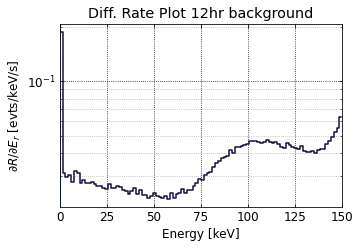

In [112]:
rateplot = darklim.sensitivity.RatePlot(
    (0, 150),
    figsize=np.array([1.5, 1]) * (3 + 3/8),
)

rateplot.add_data(
    calibratedofamp_nos_constrained[ctrigger_nos&ctemp_mask],
    1 * tot_runtime_nos,
    efficiency=randoms_total_eff,
    #calibratedofamp[ctrigger], 1 * (total_time/60/60)/24,
)
fig, ax = rateplot.fig, rateplot.ax


ax.get_legend().remove()
#ax.set_ylim(1e3, 2e6)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
ax.set_title("Diff. Rate Plot 12hr background")
ax.axvline(0.3)

### Calibrated energy absorbed 

<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<ipython-input-113-fc82f76b84fb>:19: DeprecationWarning: invalid escape sequence \p
  ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
No handles with labels found to put in legend.


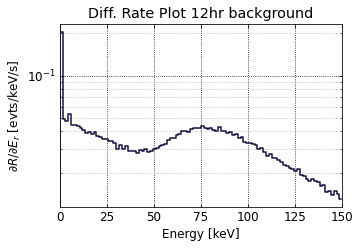

In [113]:
rateplot = darklim.sensitivity.RatePlot(
    (0, 150),
    figsize=np.array([1.5, 1]) * (3 + 3/8),
)

rateplot.add_data(
    calibratedenergy_nos[ctrigger_nos&ctemp_mask],
    1 * tot_runtime_nos,
    efficiency=randoms_total_eff,
    #calibratedofamp[ctrigger], 1 * (total_time/60/60)/24,
)
fig, ax = rateplot.fig, rateplot.ax


ax.get_legend().remove()
#ax.set_ylim(1e3, 2e6)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
ax.set_title("Diff. Rate Plot 12hr background")
ax.axvline(0.3)

## Ba

### Calibrated of amp

In [116]:
ctemp_mask = cbaseline_Ba&cchi2_temp_Ba
randoms_total_eff = 0.6875

<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<ipython-input-119-4feab0f0a5c3>:19: DeprecationWarning: invalid escape sequence \p
  ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
No handles with labels found to put in legend.


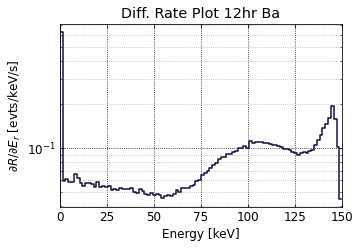

In [119]:
rateplot = darklim.sensitivity.RatePlot(
    (0, 150),
    figsize=np.array([1.5, 1]) * (3 + 3/8),
)

rateplot.add_data(
    calibratedofamp_Ba_constrained[ctrigger_Ba&ctemp_mask],
    1 * tot_runtime_Ba,
    efficiency=randoms_total_eff,
    #calibratedofamp[ctrigger], 1 * (total_time/60/60)/24,
)
fig, ax = rateplot.fig, rateplot.ax


ax.get_legend().remove()
#ax.set_ylim(1e3, 2e6)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
ax.set_title("Diff. Rate Plot 12hr Ba")
ax.axvline(0.3)

### Calibrated energy absorbed

<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<ipython-input-121-29ee896a8727>:19: DeprecationWarning: invalid escape sequence \p
  ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
No handles with labels found to put in legend.


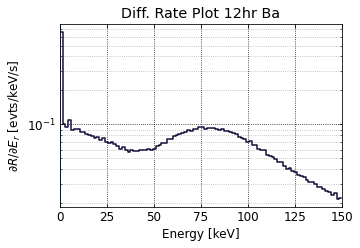

In [121]:
rateplot = darklim.sensitivity.RatePlot(
    (0, 150),
    figsize=np.array([1.5, 1]) * (3 + 3/8),
)

rateplot.add_data(
    calibratedenergy_Ba[ctrigger_Ba&ctemp_mask],
    1 * tot_runtime_Ba,
    efficiency=randoms_total_eff,
    #calibratedofamp[ctrigger], 1 * (total_time/60/60)/24,
)
fig, ax = rateplot.fig, rateplot.ax


ax.get_legend().remove()
#ax.set_ylim(1e3, 2e6)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
ax.set_title("Diff. Rate Plot 12hr Ba")
ax.axvline(0.3)

## Co

### Calibrated Of amplitude

In [122]:
ctemp_mask = cbaseline_Co&cchi2_temp_Co
randoms_total_eff = 0.6653


<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<ipython-input-123-0e9893be0d25>:19: DeprecationWarning: invalid escape sequence \p
  ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
No handles with labels found to put in legend.


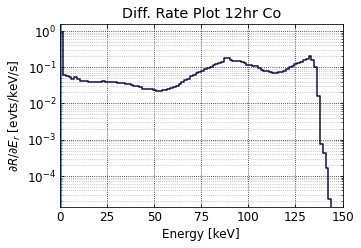

In [123]:
rateplot = darklim.sensitivity.RatePlot(
    (0, 150),
    figsize=np.array([1.5, 1]) * (3 + 3/8),
)

rateplot.add_data(
    calibratedofamp_Co_constrained[ctrigger_Co&ctemp_mask],
    1 * tot_runtime_Co,
    efficiency=randoms_total_eff,
    #calibratedofamp[ctrigger], 1 * (total_time/60/60)/24,
)
fig, ax = rateplot.fig, rateplot.ax


ax.get_legend().remove()
#ax.set_ylim(1e3, 2e6)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
ax.set_title("Diff. Rate Plot 12hr Co")
ax.axvline(0.3)

### Calibrated energy absorbed

<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<>:19: DeprecationWarning: invalid escape sequence \p
<ipython-input-124-9842bacdf882>:19: DeprecationWarning: invalid escape sequence \p
  ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
No handles with labels found to put in legend.


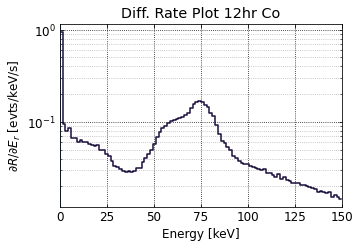

In [124]:
rateplot = darklim.sensitivity.RatePlot(
    (0, 150),
    figsize=np.array([1.5, 1]) * (3 + 3/8),
)

rateplot.add_data(
    calibratedenergy_Co[ctrigger_Co&ctemp_mask],
    1 * tot_runtime_Co,
    efficiency=randoms_total_eff,
    #calibratedofamp[ctrigger], 1 * (total_time/60/60)/24,
)
fig, ax = rateplot.fig, rateplot.ax


ax.get_legend().remove()
#ax.set_ylim(1e3, 2e6)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
ax.set_title("Diff. Rate Plot 12hr Co")
ax.axvline(0.3)

## Combined

In [87]:
from darklim.sensitivity import RatePlot

/usr/lib64/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/maggie_reed/.local/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)


In [14]:
ge_cpdv2_diameter=(3*constants.inch)*1e2 #3 inches, converted to cm
ge_cpdv2_thickness=0.1 #cm
ge_cpdv2_vol = constants.pi*(ge_cpdv2_diameter/2)**2*ge_cpdv2_thickness
ge_density = 5.323 #g/cm^3
ge_cpdv2_mass = ge_cpdv2_vol*ge_density*1e-3 #kg
print(ge_cpdv2_mass*1000,"grams")

gaas_cpdv2_diameter=(2*constants.inch)*1e2 #2 inches, converted to cm
gaas_cpdv2_thickness= 1 #cm
gaas_cpdv2_vol = constants.pi*(gaas_cpdv2_diameter/2)**2*gaas_cpdv2_thickness
gaas_density = 5.323 #g/cm^3
gaas_cpdv2_mass = gaas_cpdv2_vol*gaas_density*1e-3 #kg
print(gaas_cpdv2_mass*1000,"grams")

#exposure units are in [kg-days]
#so for run20 stuff, 24[g] * runtime[sec]/24[hours] -> g/sec
#and for run19 stuff, 100[g] * runtime[sec]/24[hours] -> g/sec

24.27483520112382 grams
107.88815644943922 grams


<>:29: DeprecationWarning: invalid escape sequence \p
<>:29: DeprecationWarning: invalid escape sequence \p
<>:29: DeprecationWarning: invalid escape sequence \p
<ipython-input-105-ec06fa4b9427>:29: DeprecationWarning: invalid escape sequence \p
  ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")


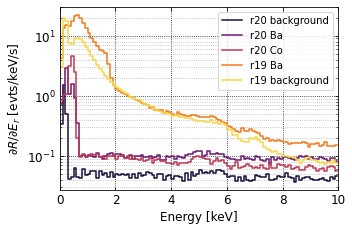

In [105]:
rateplot = RatePlot(
    (0, 10),
    figsize=np.array([1.5, 1]) * (3 + 3/8),
)
fig, ax = rateplot.fig, rateplot.ax

rateplot.add_data(
    calibratedenergy_nos[ctrigger_nos&cbaseline_nos&c_sqglitch_nos&cchi2_temp_nos],
    1 * (tot_runtime_nos), efficiency = 0.66, label = 'r20 background'
)
rateplot.add_data(
    calibratedenergy_Ba[ctrigger_Ba&cbaseline_Ba&cchi2_temp_Ba], 1 * (tot_runtime_Ba), 
    efficiency = 0.6875, label='r20 Ba'
)
rateplot.add_data(
    calibratedenergy_Co[ctrigger_Co&cbaseline_Co&cchi2_temp_Co], 1 * (tot_runtime_Co), 
    efficiency = 0.6653, label='r20 Co'
)
rateplot.add_data(
    calibratedenergy_r19Ba[ctrigger_r19Ba&cbaseline_r19Ba&cchi2_temp_r19Ba], 100/24 * (tot_runtime_r19Ba), 
    efficiency = 0.1074, label='r19 Ba'
)
rateplot.add_data(
    calibratedenergy_noBa[ctrigger_noBa&cbaseline_noBa&cchi2_temp_noBa], 100/24 * (tot_runtime_noBa), 
    efficiency = 0.1357, label='r19 background'
)
ax.set_title('')
ax.get_legend()
ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
#ax.set_ylim(1e3, 2e6)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')

fig.tight_layout()
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/drde_all_normalized.png',
    dpi=500,
    facecolor='none',
)
#''';

<>:29: DeprecationWarning: invalid escape sequence \p
<>:29: DeprecationWarning: invalid escape sequence \p
<>:29: DeprecationWarning: invalid escape sequence \p
<ipython-input-106-31f8712309df>:29: DeprecationWarning: invalid escape sequence \p
  ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")


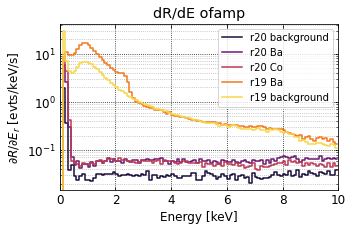

In [106]:
rateplot = RatePlot(
    (0, 10),
    figsize=np.array([1.5, 1]) * (3 + 3/8),
)
fig, ax = rateplot.fig, rateplot.ax

rateplot.add_data(
    calibratedofamp_nos_constrained[ctrigger_nos&cbaseline_nos&c_sqglitch_nos&cchi2_temp_nos],
    1 * (tot_runtime_nos), efficiency = 0.66, label = 'r20 background'
)
rateplot.add_data(
    calibratedofamp_Ba_constrained[ctrigger_Ba&cbaseline_Ba&cchi2_temp_Ba], 1 * (tot_runtime_Ba), 
    efficiency = 0.6875, label='r20 Ba'
)
rateplot.add_data(
    calibratedofamp_Co_constrained[ctrigger_Co&cbaseline_Co&cchi2_temp_Co], 1 * (tot_runtime_Co), 
    efficiency = 0.6653, label='r20 Co'
)
rateplot.add_data(
    calibratedofamp_r19Ba_constrained[ctrigger_r19Ba&cbaseline_r19Ba&cchi2_temp_r19Ba], 100/24 * (tot_runtime_r19Ba), 
    efficiency = 0.1074, label='r19 Ba'
)
rateplot.add_data(
    calibratedofamp_noBa_constrained[ctrigger_noBa&cbaseline_noBa&cchi2_temp_noBa], 100/24 * (tot_runtime_noBa), 
    efficiency = 0.1357, label='r19 background'
)
ax.set_title('dR/dE ofamp')
ax.get_legend()
ax.set_ylabel("$\partial R/\partial E_r$ [evts/keV/s]")
#ax.set_ylim(1e3, 2e6)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')

fig.tight_layout()
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/drde_all_normalized.png',
    dpi=500,
    facecolor='none',
)
#''';

# Other

In [22]:
#this creates a chi squared cut to use on randoms, that selects data with chi squared within 3 standard deviations of the mean
#in a chi squared distribution, the mean is the number of degrees of freedom and the variance is twice that
#the st dev is the square root of the variance
samplerate=fs
chi_thresh= int(tracelength*samplerate) + 3 * np.sqrt(2 * int(tracelength*samplerate))
chi_thresh_lower= int(tracelength*samplerate) - 3 * np.sqrt(2 * int(tracelength*samplerate))
crandschisqared = ((df.ofchi2_nodelay_CPDv21Ge < chi_thresh) & (df.ofchi2_nodelay_CPDv21Ge > chi_thresh_lower))

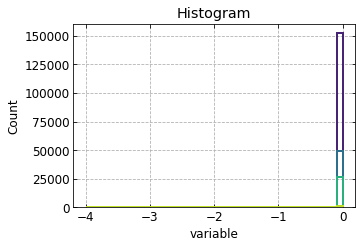

In [136]:

fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/8))
_, ax = dp.hist(
   df.baseline_CPDv21Ge,
    xlims=(-4,-0),
#    ylims=(),
    ax=ax,
    nbins=50,
#     cmap='binary_r',
    cuts=[ctrigger&cgood_time,ctemp_up,ctemp_loose,ctemp_tenfifteenkev],
    lgcrawdata=False,
    lgclegend=False,
)
ax.set_yscale('linear')


39.82751844259718

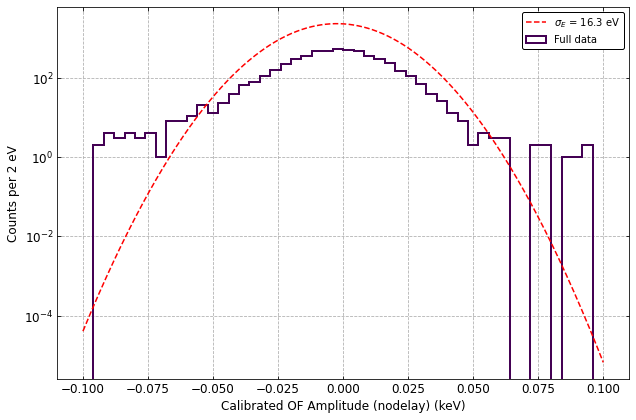

In [50]:
fig, ax = dp.hist(
    calibratedofamp_nodelay[crandoms&crandschisqared],
    nbins=50,
    xlims=(-0.1,0.1),
    labeldict = {'title' : None,
                'xlabel' : 'Calibrated OF Amplitude (nodelay) (keV)',
                'ylabel' : 'Counts per 2 eV',
                },
)
x_mean, x_std, _ = qp.cut.iterstat(calibratedofamp_nodelay[crandoms&crandschisqared])

xx = np.linspace(-0.10, 0.10, num=1000)

hist, bin_edges = np.histogram(calibratedofamp_nodelay, bins=50, range=(-.10, .10))
norm = hist.sum() * np.mean(np.diff(bin_edges))

yy = stats.norm.pdf(xx, scale=x_std, loc=x_mean) * norm

ax.plot(
    xx,
    yy,
    color='r',
    linestyle='dashed',
    label=r'$\sigma_E$' + f' = {x_std*1000:.1f} eV'
)

ax.legend(loc='upper right', framealpha=1, edgecolor='k')
fig.tight_layout()

np.std(calibratedofamp_nodelay)
#standard deviation of noise in calibrated OF amp, this is the baseline energy resolution
#we expect probably better than 20 eV



# Integrated rate above threshold

In [134]:
def calc_rate_e_depend(e_recon, exp_time, efficiency):
    sorted_e_recon = np.sort(e_recon)
    sorted_sum = np.zeros(len(sorted_e_recon))
    for ii, e in enumerate(sorted_e_recon):
        sorted_sum[ii] = len(sorted_e_recon[ii:]) / exp_time
        
    return interpolate.interp1d(
        sorted_e_recon,
        sorted_sum/efficiency,
        bounds_error=False,
        fill_value=(sorted_sum[0], sorted_sum[-1]),
    )

In [93]:
exp_time_nos = df_nos.eventtime[ctrigger_nos].iloc[-1] - df_nos.eventtime[ctrigger_nos].iloc[0]
exp_time_Ba = df_Ba.eventtime[ctrigger_Ba].iloc[-1] - df_Ba.eventtime[ctrigger_Ba].iloc[0]
exp_time_Co = df_Co.eventtime[ctrigger_Co].iloc[-1] - df_Co.eventtime[ctrigger_Co].iloc[0]
exp_time_noBa = df_noBa.eventtime[ctrigger_noBa].iloc[-1] - df_noBa.eventtime[ctrigger_noBa].iloc[0]
exp_time_r19Ba = df_r19Ba.eventtime[ctrigger_r19Ba].iloc[-1] - df_r19Ba.eventtime[ctrigger_r19Ba].iloc[0]

cmask_nos = ctrigger_nos&cgoodtime_nos&cbaseline_nos&c_sqglitch_nos&cchi2_temp_nos
cmask_Ba = ctrigger_Ba&cgoodtime_Ba&cbaseline_Ba&cchi2_temp_Ba
cmask_Co = ctrigger_Co&cgoodtime_Co&cbaseline_Co&cchi2_temp_Co

### Calibrated of Amp 

In [135]:
rate_func_nos = calc_rate_e_depend(
    calibratedofamp_nos_constrained[cmask_nos],
    exp_time_nos, efficiency = 0.66
)
rate_func_Ba = calc_rate_e_depend(
    calibratedofamp_Ba_constrained[cmask_Ba],
    exp_time_Ba, efficiency = 0.6875
)
rate_func_Co = calc_rate_e_depend(
    calibratedofamp_Co_constrained[cmask_Co],
    exp_time_Co, efficiency = 0.6653
)
rate_func_noBa = calc_rate_e_depend(
    calibratedofamp_noBa_constrained[cgoodevents_noBa],
    exp_time_noBa/(100/24), efficiency = 0.1357
)
rate_func_r19Ba = calc_rate_e_depend(
    calibratedofamp_r19Ba_constrained[cgoodevents_r19Ba],
    exp_time_r19Ba/(100/24), efficiency = 0.1074
)

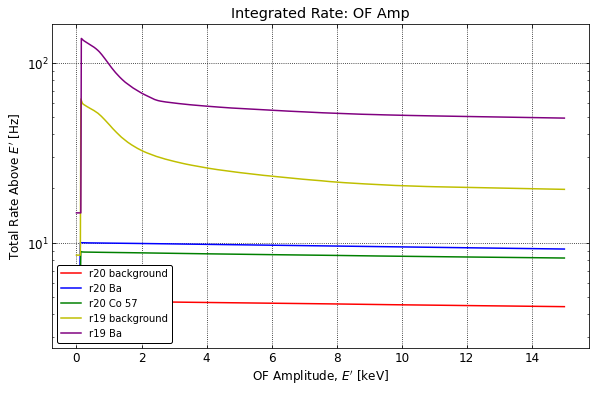

In [138]:
fig, ax = plt.subplots(figsize=(5 + 5/8) * np.array([1.5, 1]))

energies_plot = np.linspace(0, 15, num=1000)
ax.plot(
    energies_plot,
    rate_func_nos(energies_plot),
    color='r',
    label='r20 background',
)
ax.plot(
    energies_plot,
    rate_func_Ba(energies_plot),
    color='b',
    label='r20 Ba',
)
ax.plot(
    energies_plot,
    rate_func_Co(energies_plot),
    color='g',
    label='r20 Co 57',
)
ax.plot(
    energies_plot,
    rate_func_noBa(energies_plot),
    color='y',
    label='r19 background',
)
ax.plot(
    energies_plot,
    rate_func_r19Ba(energies_plot),
    color='purple',
    label='r19 Ba',
)
ax.set_yscale('log')
#ax.set_ylim(3, 10)
#ax.set_xlim(0.1, 1)
ax.set_ylabel(r"Total Rate Above $E'$ [Hz]")
ax.set_xlabel(r"OF Amplitude, $E'$ [keV]")
ax.set_title('Integrated Rate: OF Amp')
ax.legend(loc="lower left", framealpha=1, edgecolor='k')
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
fig.tight_layout()



### Calibrated Energy Absorbed

In [198]:
rate_func_nos = calc_rate_e_depend(
    calibratedenergy_nos[cmask_nos],
    exp_time_nos,
)
rate_func_Ba = calc_rate_e_depend(
    calibratedenergy_Ba[cmask_Ba],
    exp_time_Ba,
)
rate_func_Co = calc_rate_e_depend(
    calibratedenergy_Co[cmask_Co],
    exp_time_Co,
)

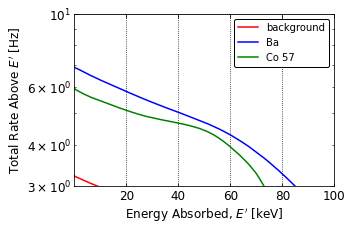

In [210]:
fig, ax = plt.subplots(figsize=(3 + 3/8) * np.array([1.5, 1]))

energies_plot = np.linspace(0, 100, num=1000)
ax.plot(
    energies_plot,
    rate_func_nos(energies_plot),
    color='r',
    label='background',
)
ax.plot(
    energies_plot,
    rate_func_Ba(energies_plot),
    color='b',
    label='Ba',
)
ax.plot(
    energies_plot,
    rate_func_Co(energies_plot),
    color='g',
    label='Co 57',
)
ax.set_yscale('log')
ax.set_ylim(3, 10)
ax.set_xlim(0.1, 100)
ax.set_ylabel(r"Total Rate Above $E'$ [Hz]")
ax.set_xlabel(r"Energy Absorbed, $E'$ [keV]")
ax.legend(loc="upper right", framealpha=1, edgecolor='k')
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k')
fig.tight_layout()

## Checking nconstrain validity

In [56]:
cthresh_one_nos = dp.inrange(calibratedofamp_nos_constrained, 0, 1)
cone_five_nos = dp.inrange(calibratedofamp_nos_constrained, 1, 5)
cfive_sat_nos = dp.inrange(calibratedofamp_nos_constrained, 5, 50)
csat_up = dp.inrange(calibratedofamp_nos_constrained, 50, np.inf)

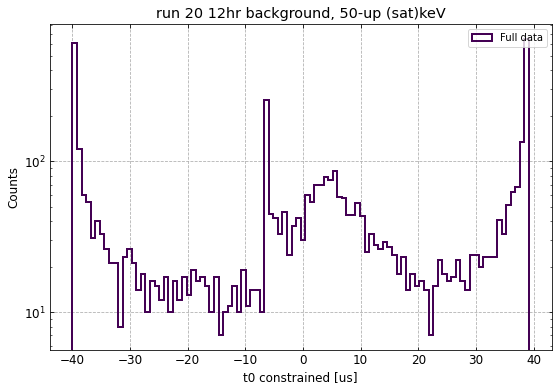

In [118]:
fig, ax = dp.hist(
    df_nos.oft0_constrained_CPDv21Ge[cgoodtime_nos&cbaseline_nos&c_sqglitch_nos&cchi2_temp_nos&cthresh_one_nos]*1e6,
    nbins=100,
    #xlims=(-4,4),
    labeldict = {'title' : 'run 20 12hr background, 50-up (sat)keV',
                'xlabel' : 't0 constrained [us]',
                'ylabel' : 'Counts',
                 'cut 0' : 'thresh-1kev'
                },
)
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_20/figs/no_source/t0hist_nos_satup.png',
    dpi=500,
    facecolor='none',
)
#''';

In [119]:
cgoodevents_nos = cgoodtime_nos&cbaseline_nos&c_sqglitch_nos&cchi2_temp_nos

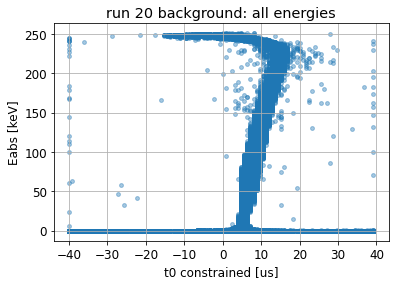

In [138]:
plt.scatter(df_nos.oft0_constrained_CPDv21Ge[cgoodevents_nos]*1e6, 
            calibratedenergy_nos[cgoodevents_nos],
            s=15, alpha=0.4, cmap='icefire' 
           )
plt.title('run 20 background: all energies')
plt.xlabel('t0 constrained [us]')
plt.ylabel('Eabs [keV]')
plt.grid()
'''
plt.savefig('/data/users/da_real_maggie_reed/analysis/run_20/figs/no_source/t0_Eabs_all.png',
    dpi=500,
    facecolor='none',)
    #''';
plt.show()

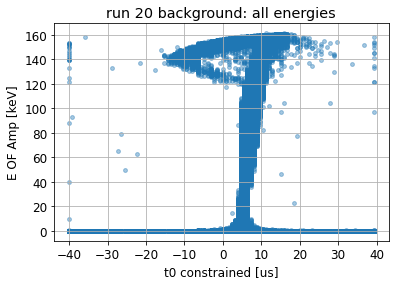

In [139]:
plt.scatter(df_nos.oft0_constrained_CPDv21Ge[cgoodevents_nos]*1e6, 
            calibratedofamp_nos_constrained[cgoodevents_nos],
            s=15, alpha=0.4, cmap='icefire' 
           )
plt.title('run 20 background: all energies')
plt.xlabel('t0 constrained [us]')
plt.ylabel('E OF Amp [keV]')
plt.grid()
'''
plt.savefig('/data/users/da_real_maggie_reed/analysis/run_20/figs/no_source/t0_Eof_all.png',
    dpi=500,
    facecolor='none',)
    #''';
plt.show()

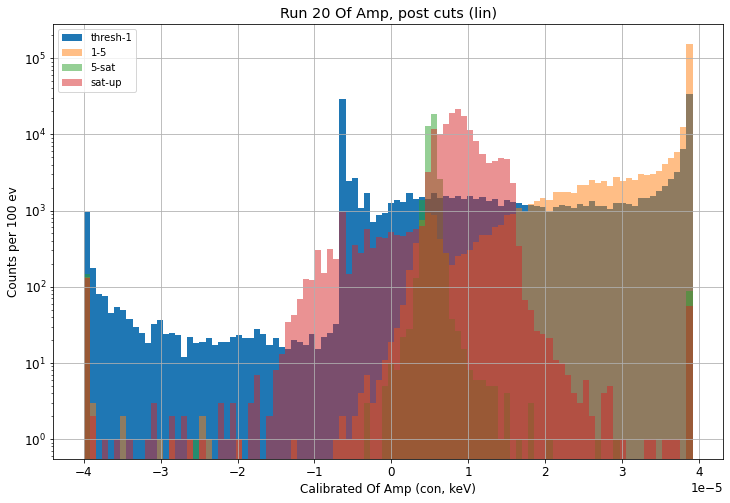

In [65]:
scaling = True
plt.figure(figsize=(12,8))
plt.hist(df_nos.oft0_constrained_CPDv21Ge[cthresh_one_nos],
        bins=100, log=scaling, label='thresh-1')
plt.hist(df_nos.oft0_constrained_CPDv21Ge[cone_five_nos],
        bins=100, log=scaling, alpha = 0.5, label='1-5')
plt.hist(df_nos.oft0_constrained_CPDv21Ge[cfive_sat_nos],
        bins=100, log=scaling, alpha = 0.5, label='5-sat')
plt.hist(df_nos.oft0_constrained_CPDv21Ge[csat_up],
        bins=100, log=scaling, alpha = 0.5, label='sat-up')
#plt.xlim(60,110)
#plt.ylim(0,600)
plt.legend(loc="upper left")
plt.title('Run 20 Of Amp, post cuts (lin)')
plt.ylabel('Counts per 100 ev')
plt.xlabel('Calibrated Of Amp (con, keV)')
plt.grid(visible=True)
'''
plt.savefig('/data/users/da_real_maggie_reed/analysis/run_20/figs/all_lin_ofamp_wide3_hist.png',
    dpi=500,
    facecolor='none',)
    #''';
plt.show()

(array([9.4500e+02, 1.7400e+02, 7.9000e+01, 7.6000e+01, 4.5000e+01,
        5.4000e+01, 5.0000e+01, 3.8000e+01, 3.0000e+01, 2.5000e+01,
        1.8000e+01, 3.2000e+01, 3.7000e+01, 2.4000e+01, 2.5000e+01,
        2.3000e+01, 1.2000e+01, 2.2000e+01, 1.8000e+01, 1.9000e+01,
        2.1000e+01, 1.7000e+01, 1.9000e+01, 1.9000e+01, 2.2000e+01,
        2.3000e+01, 2.1000e+01, 2.1000e+01, 2.8000e+01, 2.4000e+01,
        1.7000e+01, 2.1000e+01, 1.6000e+01, 1.5000e+01, 2.0000e+01,
        1.9000e+01, 1.7000e+01, 2.4000e+01, 1.5000e+01, 2.2000e+01,
        2.5000e+01, 3.2000e+01, 2.8681e+04, 2.4290e+03, 2.6530e+03,
        1.0840e+03, 1.7210e+03, 7.0700e+02, 8.7500e+02, 9.3100e+02,
        1.2550e+03, 1.3890e+03, 1.2970e+03, 1.6750e+03, 1.3970e+03,
        1.5000e+03, 1.4370e+03, 1.7140e+03, 1.4640e+03, 1.5670e+03,
        1.4500e+03, 1.5450e+03, 1.3960e+03, 1.5380e+03, 1.4370e+03,
        1.4970e+03, 1.3440e+03, 1.4120e+03, 1.1300e+03, 1.3820e+03,
        1.3100e+03, 1.2720e+03, 1.1830e+03, 1.19

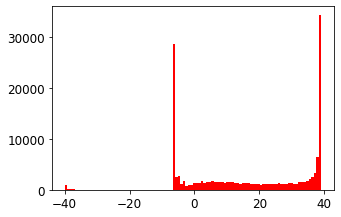

In [62]:
fig, ax = plt.subplots(figsize=(3 + 3/8) * np.array([1.5, 1]))
ax.hist(df_nos.oft0_constrained_CPDv21Ge[cthresh_one_nos]*1e6, bins=100,color='r',label='thresh-1')

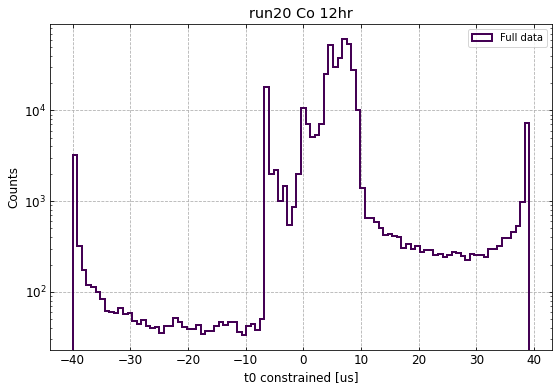

In [19]:
fig, ax = dp.hist(
    df_Co.oft0_constrained_CPDv21Ge*1e6,
    nbins=100,
    #xlims=(-4,4),
    labeldict = {'title' : 'run20 Co 12hr',
                'xlabel' : 't0 constrained [us]',
                'ylabel' : 'Counts',
                },
)

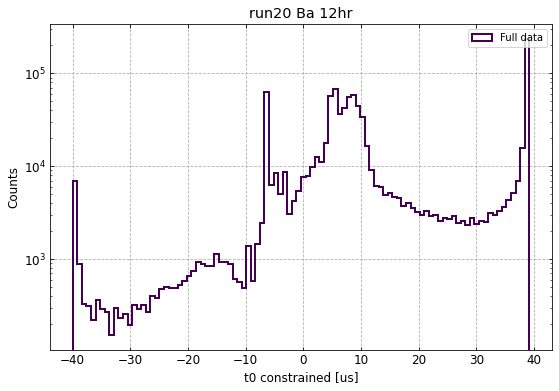

In [18]:
fig, ax = dp.hist(
    df_Ba.oft0_constrained_CPDv21Ge*1e6,
    nbins=100,
    #xlims=(-4,4),
    labeldict = {'title' : 'run20 Ba 12hr',
                'xlabel' : 't0 constrained [us]',
                'ylabel' : 'Counts',
                },
)

# Cut efficiencies function

In [67]:
def cutefficiencies(cut_array,cut_index, suffix, trigsuffix, randsuffix, energy_cut_array=None,columns=None,basecut=None,energy_ranges=None):
    calibratedofamp = suffix
    ctrigger = trigsuffix
    crandoms = randsuffix
    if basecut == None:
        basecut=dp.inrange(calibratedofamp,-np.inf,np.inf)
    
    if columns == None:
        columns=['Randoms - Differential Efficiency','Randoms - Total Efficiency']
        if energy_cut_array == None:
            columns.append('Trigger - Differential Efficiency')
            columns.append('Trigger - Total Efficiency')
        else:
            if energy_ranges == None:
                for count, energycut in enumerate(energy_cut_array):
                    columns.append(f'Trigger - Differential Efficiency - range {count+1}')
                    columns.append(f'Trigger - Total Efficiency - range {count+1}')
            else: 
                if len(energy_cut_array) != len(energy_ranges):
                    return "Error - energy_range and energy_cut_array length do not match"
                else:
                    for count, e_range in enumerate(energy_ranges):
                        columns.append(f'Trigger ({e_range})- Differential Efficiency')
                        columns.append(f'Trigger ({e_range})- Total Efficiency')
    
    eff_array=[]
    
    for count, cut in enumerate(cut_array):
        cut_random_diff=sum(cut&basecut&crandoms)/sum(crandoms&basecut)
        cut_random_tot=sum(cut&basecut&crandoms)/sum(crandoms)
        cut_ind=[cut_random_diff,cut_random_tot]
        if energy_cut_array == None:
            cut_trigger_diff=sum(cut&basecut&ctrigger)/sum(ctrigger&basecut)
            cut_trigger_tot=sum(cut&basecut&ctrigger)/sum(ctrigger)
            cut_ind.append(cut_trigger_diff)
            cut_ind.append(cut_trigger_tot)
        else:
            for n, energycut in enumerate(energy_cut_array):
                cut_trigger_diff=sum(cut&basecut&ctrigger&energycut)/sum(ctrigger&basecut&energycut)
                cut_trigger_tot=sum(cut&basecut&ctrigger&energycut)/sum(ctrigger&energycut)
                cut_ind.append(cut_trigger_diff)
                cut_ind.append(cut_trigger_tot)
        eff_array.append(cut_ind)
        basecut=basecut&cut
    cut_table=pd.DataFrame(eff_array,
                           columns=columns,
                           index=cut_index)
    return cut_table.head()

In [66]:
fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/8))
bins=100
_, ax = dp.hist(
   calibratedofamp,
 #   xlims=(0, 2),
    ax=ax,
    nbins=100,
#     cmap='binary_r',
    cuts=[ctrigger, cgood_time, cbaseline1, ctemp_loose],
    lgcrawdata=False,
    labeldict = {'title' : 'Efficiencies, loose chi2',
                'xlabel' : 'Calibrated OF Amplitude (uncon) (keV)',
                'ylabel' : (f'Counts per {int((bins[1] - bins[0]) / nbins)} eV')
                 
                 

SyntaxError: invalid syntax (<ipython-input-66-7085f8b92542>, line 14)

In [218]:
#paranoid checking the fall time of the presat fit pos delchi2
#averaging and time shifting lower
x_temp_low = np.zeros(posdelchi2_x.shape)
for ii in range(posdelchi2_x.shape[0]):
    ts = np.roll(posdelchi2_x[ii,0],-int(df_both.oft0_constrained_CPDv21Ge_up[cout_posdelchi2].iloc[ii]*fs))
    ts-= np.mean(ts[0:6000])
    x_temp_low[ii] = ts/ts.max()

x_avg_low = np.mean(x_temp_low, axis = 0) 

Text(0.5, 1.0, 'posdelchi2 presat 1000 averaged normalized traces')

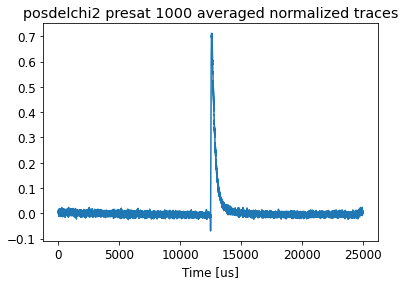

In [219]:
plt.plot(x_avg_low[0])
plt.xlabel('Time [us]')
#plt.ylabel('Current [uA]')
plt.title('posdelchi2 presat 1000 averaged normalized traces')

In [220]:
with open(yaml_path) as f:
    yaml_dict = yaml.load(f)
NLIN = (qp.OFnonlin(np.loadtxt
                (yaml_dict['CPDv21Ge']
                ['psd_path']) * 1e-20, 1.25e6)
       )

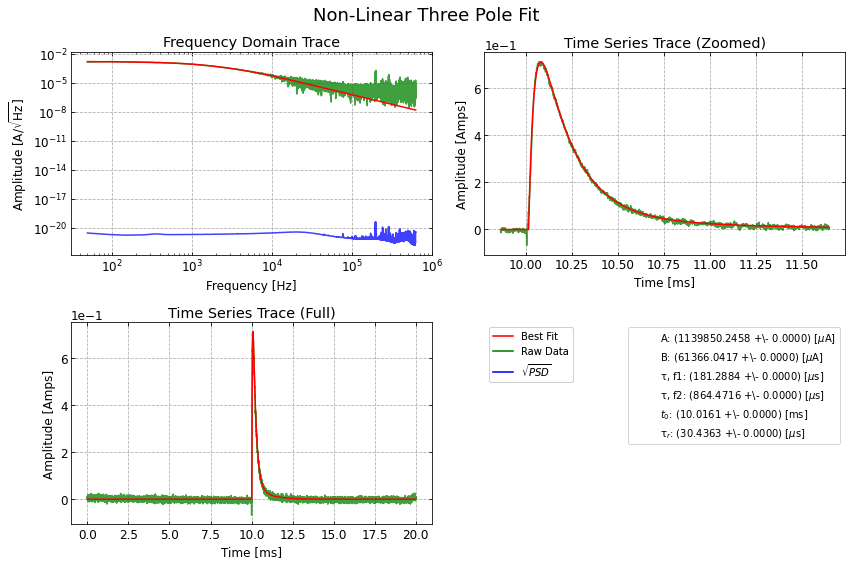

In [222]:
#three pole fit for template of the lower cuts

#returns amplitude or pulse height, rise time, fall time, time offset 
low_gooda, low_goodb, low_goodrise, low_goodf1, low_goodf2, low_tao = (NLIN.fit_falltimes(
    x_avg_low[0], npolefit=3, guess=(1, 0.5, 10e-6, 60e-6, 1000e-6, 10e-3), lgcplot=True))